In [1]:
import os
import sys
import numpy as np
import pickle
import seaborn
import pandas
import copy as cp
import scipy.stats
import math

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
sys.path.insert(1, '../code/')

from rank_functions import compute_mean_ranks, compute_transformed_Rmat, transform_ranks
from plot_functions import compute_meta_p, compute_enrichment, plot_enrichment, compute_avg_sign_matrix
from plot_functions import make_fpr_figure_individual
from format_helper_functions import make_aa_dict

In [4]:
# plotting settings
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = 'Arial'
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Arial"] + plt.rcParams["font.serif"]

In [5]:
# whether to save the plots
save = True

# results for each block
indir_1 = '../results/fuzzy/1255/'
indir_2 = '../results/fuzzy/1257/'

datadir_1 = indir_1
datadir_2 = indir_2

# protein names
protein_1 = 'block_1'
protein_2 = 'block_2'
ligand_1  = 'cript_1'
ligand_2  = 'cript_2'

# make output director
outdir  = os.path.join ('../results/fuzzy', 'plots')
if not os.path.isdir (outdir) :
    os.makedirs (outdir)

In [6]:
# some hard coded parameters
nAA   = 21
start = 303


# wildtype sequences
lig_wt      = 'KNYKQTSV'
pdz_wt_full = 'GEEDIPREPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEYSRFEA'

# wildtype in rep 1
n0_wt_1 = np.array ([20012, 21754, 27243])
n1_wt_1 = np.array ([68933, 71382, 52736])
n0_wt_2 = np.array ([10743, 11617, 13052])
n1_wt_2 = np.array ([61066, 122991, 40364])

# labels for the ligand
lig_labels = [lig_wt[i] + '-' + str (len (lig_wt)-1-i) for i in range (len (lig_wt))]
lig_labels[-1] = 'V0'
print (lig_labels)

['K-7', 'N-6', 'Y-5', 'K-4', 'Q-3', 'T-2', 'S-1', 'V0']


In [7]:
mypinks  = seaborn.color_palette ('rocket_r', 10)
mycolors = seaborn.color_palette('magma', nAA)
aacolors = seaborn.color_palette('Set2', 9)
myspectral = seaborn.color_palette ('Spectral', 8)
myblues = seaborn.color_palette ('Blues', 8)

# amino acid dictionary
aa_dict = make_aa_dict (stop='*')
aas     = list (aa_dict.keys ())

In [8]:
# raw data files
ysing_1 = np.loadtxt (os.path.join (datadir_1, protein_1 + '_Y_singles.txt'))
lsing_1 = np.loadtxt (os.path.join (datadir_1, ligand_1 + '_Y_singles.txt'))
ydoub_1 = pickle.load ( open (os.path.join (datadir_1, protein_1 + '_Y_doubles.pkl'), 'rb') )

n0_doub_1 = pickle.load (open (os.path.join (datadir_1, protein_1 + '_D_neutral.pkl'), 'rb') )
n1_doub_1 = pickle.load (open (os.path.join (datadir_1, protein_1 + '_D_selection.pkl'), 'rb') )

n0_sing_1  = np.loadtxt (os.path.join (datadir_1, protein_1 + '_S_neutral.txt'))
n1_sing_1  = np.loadtxt (os.path.join (datadir_1, protein_1 + '_S_selection.txt'))
n0_cript_1 = np.loadtxt (os.path.join (datadir_1, ligand_1 + '_S_neutral.txt'))
n1_cript_1 = np.loadtxt (os.path.join (datadir_1, ligand_1 + '_S_selection.txt'))

# distance matrix
Dist = np.loadtxt ('../data/fuzzy/pdz_distance_matrix.txt')

In [9]:
# raw data files
ysing_2 = np.loadtxt (os.path.join (datadir_2, protein_2 + '_Y_singles.txt'))
lsing_2 = np.loadtxt (os.path.join (datadir_2, ligand_2 + '_Y_singles.txt'))
ydoub_2 = pickle.load ( open (os.path.join (datadir_2, protein_2 + '_Y_doubles.pkl'), 'rb') )

n0_doub_2 = pickle.load (open (os.path.join (datadir_2, protein_2 + '_D_neutral.pkl'), 'rb') )
n1_doub_2 = pickle.load (open (os.path.join (datadir_2, protein_2 + '_D_selection.pkl'), 'rb') )

n0_sing_2  = np.loadtxt (os.path.join (datadir_2, protein_2 + '_S_neutral.txt'))
n1_sing_2  = np.loadtxt (os.path.join (datadir_2, protein_2 + '_S_selection.txt'))
n0_cript_2 = np.loadtxt (os.path.join (datadir_2, ligand_2 + '_S_neutral.txt'))
n1_cript_2 = np.loadtxt (os.path.join (datadir_2, ligand_2 + '_S_selection.txt'))

In [10]:
# dimensions
Llig, L1, nreps = n0_doub_1.shape
Llig, L2, nreps = n0_doub_2.shape

npdz = int (L1 / nAA)
npos = npdz
ncript = int (Llig / nAA)
L = L1

In [11]:
# p-values
Pvals = np.zeros ( (2, Llig, L, nreps))
Pligs = np.zeros ( (2, Llig, L, nreps) )
Psym  = np.zeros_like (Pvals)
Dmats = np.zeros_like (Pvals)
Lmats = np.zeros ( (2, L, Llig, nreps))
Dsyms = np.zeros_like (Pvals)
Rmats = np.zeros_like (Pvals)
RLmats = np.zeros_like (Pvals)
indirs   = [indir_1, indir_2]
proteins = [protein_1, protein_2]
for ct in range (len (indirs)) :
    idir = indirs[ct]    
    protein = proteins[ct]
    for i in range (nreps) :
        #Pvals[ct,:,:,i] = np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_P.txt'))
        Pligs[ct,:,:,i] = np.transpose (np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_Pligand.txt')))
        Psym[ct,:,:,i]  = np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_Psymmetric.txt'))
        Dmats[ct,:,:,i] = np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_Dmat.txt'))
        Lmats[ct,:,:,i] = np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_LDmat.txt'))
        Rmats[ct,:,:,i] = np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_Rmat.txt'))
        RLmats[ct,:,:,i] = np.transpose (np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_Lmat.txt')))

        # find appropriate scaling factors
        a_val = np.max (np.sum (~np.isnan (Dmats[ct,:,:,i]), axis=1))
        b_val = np.max (np.sum (~np.isnan (Lmats[ct,:,:,i]), axis=1))
        print ((a_val, b_val))

        Dsyms[ct,:,:,i]   = Dmats[ct,:,:,i] * (b_val / a_val) + np.transpose (Lmats[ct,:,:,i])
        Pvals[ct,:,:,i] = np.loadtxt (os.path.join (idir, 'rep_' + str (i), protein + '_Psymmetric_scaled.txt'))

(671, 154)
(721, 154)
(733, 154)
(836, 154)
(839, 154)
(840, 154)


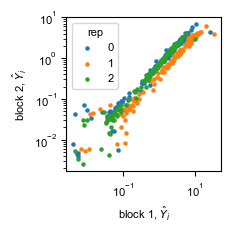

In [12]:
plt.rcParams["figure.figsize"] = (2,2)

for i in range (nreps) :
    plt.scatter (lsing_1[:,i], lsing_2[:,i], s=5, label=i)
    
plt.legend (title='rep')
plt.xlabel ('block 1, $\hat Y_i$')
plt.ylabel ('block 2, $\hat Y_i$')
plt.xscale ('log')
plt.yscale ('log')
plt.show ()

In [13]:
tots  = np.zeros ( (6, nreps) )
for i in range (nreps) :
    tots[0,i] = np.sum (~np.isnan (Pvals[0,:,:,i]))
    tots[1,i] = np.sum (~np.isnan (Pvals[1,:,:,i]))
    tots[2,i] = np.sum (~np.isnan (ysing_1[:,i]))
    tots[3,i] = np.sum (~np.isnan (ysing_2[:,i]))
    tots[4,i] = np.sum (~np.isnan (n0_cript_1[:,i]))
    tots[5,i] = np.sum (~np.isnan (n0_cript_2[:,i]))
    
print (np.nanmean (tots, axis=1))

print (np.nanmean (n0_doub_1))
print (np.nanmean (n0_doub_2))
print (np.nanmean (n0_cript_1))
print (np.nanmean (n0_cript_2))
print (np.nanmean (n0_sing_1))
print (np.nanmean (n0_sing_2))

[ 91017.33333333 122886.66666667    791.33333333    840.
    154.            154.        ]
30.943495051631196
31.05971626973363
7816.060606060606
6332.547619047619
220.99073294018535
287.231746031746


In [14]:
npos = 43
dids_1 = np.arange (0, npos+7, 1)  # subset distance matrix
dids_2 = np.append (np.arange (0,7,1), np.arange (50+7, 50+7+npos, 1))

# subset distance matrix
Df_1 = cp.deepcopy (Dist[dids_1,:][:,dids_1][:7,7:])
Df_2 = cp.deepcopy (Dist[dids_2,:][:,dids_2][:7,7:])

In [15]:
# compute missing data
for bj in range (2) :
    print ('Block ' + str (bj))
    vals = np.zeros (nreps)
    svals = np.zeros (nreps)
    for i in range (nreps) :
        vals[i] = np.sum (~np.isnan (Pvals[bj,:,:,i])) / (npdz * ncript * (nAA - 1)**2)
        if bj == 0 :
            svals[i] = np.sum (~np.isnan (ysing_1[:,i])) / (npdz * (nAA -1))
        else :
            svals[i] = np.sum (~np.isnan (ysing_2[:,i])) / (npdz * (nAA -1))

    print (vals)
    print (np.nanmean (vals))
    print (svals)
    print (np.nanmean (svals))

Block 0
[0.60579942 0.68131541 0.69727471]
0.6614631782945737
[0.93488372 0.90465116 0.92093023]
0.92015503875969
Block 1
[0.88180233 0.89258721 0.90482558]
0.8930717054263567
[0.97674419 0.97674419 0.97674419]
0.9767441860465116


In [16]:
# compute meta ps
meta_P1 = compute_meta_p (Pvals[0,:,:,:], omit=True, nthres=2 )
meta_P2 = compute_meta_p (Pvals[1,:,:,:], omit=True, nthres=2 )

# remove stop codons
nl_idxs = np.arange (nAA-1,nAA,Llig)
n_idxs  = np.arange (nAA-1,nAA,L)
 
meta_P1[nl_idxs,:] = np.nan
meta_P1[:,n_idxs]  = np.nan
meta_P2[nl_idxs,:] = np.nan
meta_P2[:,n_idxs]  = np.nan

In [17]:
# add row of missing values to distance matrices
Df_1a = np.row_stack ([np.repeat (np.nan, npos), Df_1])
Df_2a = np.row_stack ([np.repeat (np.nan, npos), Df_2])

In [18]:
# compute false positive rates and accuracy for mochi over a range of alphas
fdr_alpha = .1
alphas   = np.logspace (-2,np.log10 (.5),100)
accuracy = np.zeros ( (2, len (alphas), 2))
prop     = np.zeros ( (2, len (alphas), 2))

for i in range (2) :
    if i == 0 :
        pvals_i = cp.deepcopy (meta_P1)
        Df      = cp.deepcopy (Df_1a)
    elif i == 1 :
        pvals_i = cp.deepcopy (meta_P2)
        Df      = cp.deepcopy (Df_2a)
    
    ct = 0
    for a in alphas :
        Ep, Et = compute_enrichment (pvals_i, alpha=a)

        fpcow = scipy.stats.false_discovery_control (np.ndarray.flatten (Ep), method='bh')
        fpthres = np.nanmax (np.ndarray.flatten (Ep)[fpcow < fdr_alpha])
        accuracy[i,ct,0] = np.sum (np.logical_and (Ep <= fpthres, Df <= 5)) / np.sum (Ep <= fpthres)
        prop[i,ct,0]     = (np.sum (np.logical_and (Ep <= fpthres, Df <= 5)) / np.sum (Df <= 5))

        accuracy[i,ct,1] = np.sum (np.logical_and (Ep <= fpthres, Df <= 8)) / np.sum (Ep <= fpthres)
        prop[i,ct,1]     = (np.sum (np.logical_and (Ep <= fpthres, Df <= 8)) / np.sum (Df <= 8))
        ct += 1

In [19]:
# find alpha values that maximize sum of accuracy and proportion
alpha_enrich = np.zeros ((2,2))
for i in range (2) :
    for j in range (2) :
        alpha_enrich[i,j] = alphas[np.nanargmax (accuracy[i,:,j] + prop[i,:,j])]

print (alpha_enrich)

[[0.03404087 0.03404087]
 [0.02118678 0.02118678]]


In [20]:
plt.rcParams["figure.figsize"] = (4,2)

fig, axs = plt.subplots (1, 2, sharex=False, sharey=True, constrained_layout=True)

for i in range (2) :
    myp = axs[i].scatter (prop[i,:,0], accuracy[i,:,0], alpha=0.8,
                 s=20, c=alphas, cmap='rocket', norm=mpl.colors.LogNorm (),
                 edgecolor='black', linewidth=.05)
    if i == 1 :
        cbar = fig.colorbar (myp, ax=axs[i], shrink=.75, label=r'$\alpha$', aspect=17, pad=.05)
        cbar.set_label(r'$\alpha$', labelpad=-10, loc='top', rotation=360)

    myp = axs[i].scatter (prop[i,:,1], accuracy[i,:,1], alpha=0.8,
                 s=20, c=alphas, cmap='Blues_r', norm=mpl.colors.LogNorm (),
                 edgecolor='black', linewidth=0.05)
   
    axs[i].set_xlabel ('Prop. contacts')
    if i == 0 :
        axs[i].set_ylabel ('$pseudo$-accuracy')
    axs[i].set_title ('block ' + str (i+1))
    axs[i].set_xlim ((0, np.nanmax (prop[i,:,:]) + .05))
    
    if i == 1 :
        cbar = fig.colorbar (myp, ax=axs[i], shrink=.75, aspect=17)
        cbar.ax.set_yticklabels([])

        
    axs[i].tick_params (length=2)
    axs[i].xaxis.set_tick_params (pad=2)
    axs[i].yaxis.set_tick_params (pad=1.5)
        
if save :
    plt.savefig (os.path.join (outdir, 'pdz_contact_accuracy.pdf'),
                 transparent=True, dpi=600, format='pdf', bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [21]:
alpha_enrich

array([[0.03404087, 0.03404087],
       [0.02118678, 0.02118678]])

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2117305302.py:10: RuntimeWarning: Mean of empty slice
  positive=True, Sign=np.nanmean (Dsyms[0,:,:,:], axis=2))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2117305302.py:13: RuntimeWarning: Mean of empty slice
  plot_enrichment (Emat=Epos, Dmat=np.nanmean (Dsyms[0,:,:,:], axis=2),


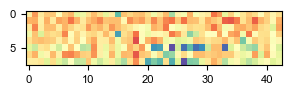

[4 6 6]
cows


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2117305302.py:23: RuntimeWarning: Mean of empty slice
  Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2117305302.py:26: RuntimeWarning: Mean of empty slice
  plot_enrichment (Emat=Epos, Dmat=np.nanmean (Dsyms[1,:,:,:], axis=2),
/Users/maryncarlson/nitmb/resample_and_reorder/notebooks/../code/plot_functions.py:1120: RuntimeWarning: Mean of empty slice
  avgSign[i,j] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])


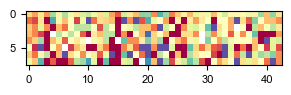

[5]
cows


In [22]:
# compute enrichment

npos = 43
Df_1a = np.row_stack ([np.repeat (np.nan, npos), Df_1])
Df_2a = np.row_stack ([np.repeat (np.nan, npos), Df_2])

# block 1
Epos, Etot      = compute_enrichment (meta_P1, alpha=alpha_enrich[0,0])
Eplus, Etotplus = compute_enrichment (meta_P1, alpha=alpha_enrich[0,0],
                                  positive=True, Sign=np.nanmean (Dsyms[0,:,:,:], axis=2))

# plot
plot_enrichment (Emat=Epos, Dmat=np.nanmean (Dsyms[0,:,:,:], axis=2),
                 Ps=meta_P1, alpha=alpha_enrich[0,0],
                 Dist=Df_1a,
                 Posmat=Eplus, pdf=False,
                 protein='CRIPT', ligand='block 1', outlabel='block_1',
                 start=303, startlig=0, save=save, outdir=outdir, liglabels=lig_labels, aspect=1.15)

# block 2
Epos, Etot      = compute_enrichment (meta_P2, alpha=alpha_enrich[1,0])
Eplus, Etotplus = compute_enrichment (meta_P2, alpha=alpha_enrich[1,0], positive=True,
                                  Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))

# plot
plot_enrichment (Emat=Epos, Dmat=np.nanmean (Dsyms[1,:,:,:], axis=2),
                 Ps=meta_P2, alpha=.05,#alpha_enrich[1,0],
                 Dist=Df_2a,
                 Posmat=Eplus, pdf=False,
                 protein='CRIPT', ligand='block 2', outlabel='block_2',
                 start=353, startlig=0, save=save, outdir=outdir, liglabels=lig_labels, aspect=1.15)

In [23]:
plt.rcParams["figure.figsize"] = (3,3)

fig, axs = plt.subplots (4, 2, sharex=True, sharey=True)

#axs[0].set_ylim ((-0.05,27500))
for ct in range (len (indirs)) :
    axs[-1, ct].set_xlabel (r'$p$-value')
    axs[0,ct].set_title ('block ' + str (ct+1), fontsize=8)

    for i in range (nreps) :
        axs[i,ct].hist (np.ndarray.flatten (Psym[ct,:,:,i]), label=r'$p_{ij}$', bins=20,
                        color='lightgray', edgecolor='black', linewidth=.01)
        if ct == 0 :
            axs[i,ct].set_ylabel ('Count', labelpad=0)
        axs[i,ct].annotate ( 'rep ' + str (i+1), (0,8000), fontsize=8)
        axs[0,ct].set_yticks ([0,10000], ['0', r'$10^{4}$'])
        

    axs[-1,ct].annotate ( 'meta', (0,8000), fontsize=8)

axs[-1,0].hist (np.ndarray.flatten (meta_P1), label=r'$\tilde p_{ij}$',
                color='darkgray', edgecolor='black', linewidth=.01, bins=20)
axs[-1,1].hist (np.ndarray.flatten (meta_P2), label=r'$\tilde p_{ij}$',
                color='darkgray', edgecolor='black', linewidth=.01, bins=20)
    
axs[-1,0].set_ylabel ('Count', labelpad=0)

for i in range (4) :
    for j in range (2) :
        axs[i,j].tick_params (length=2)
        axs[i,j].xaxis.set_tick_params (pad=2)
        axs[i,j].yaxis.set_tick_params (pad=1.5)

if save :
    plt.savefig (os.path.join (outdir, 'pij_values.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [24]:
# compute AA distance matrix
bigDist = np.zeros ((2,Llig,L1)) * np.nan
for i in range (1,ncript) :
    bigDist[0,(i*nAA):(i*nAA + nAA),:] = np.reshape (np.repeat (Df_1[i-1,:], nAA**2), (nAA, L1), order='F')
    bigDist[1,(i*nAA):(i*nAA + nAA),:] = np.reshape (np.repeat (Df_2[i-1,:], nAA**2), (nAA, L2), order='F')

In [25]:
# Distance plot for positive interactions
start_1 = 303
avgSign = compute_avg_sign_matrix (np.nanmean (Dsyms[0,:,:,:], axis=2), meta_P1)
Eplus, Eplustot = compute_enrichment (meta_P1, alpha=alpha_enrich[0,0],
                                  positive=True, Sign=np.nanmean (Dsyms[0,:,:,:], axis=2))

start_2 = 353
avgSign_2 = compute_avg_sign_matrix (np.nanmean (Dsyms[1,:,:,:], axis=2), meta_P2)
Eplus_2, Eplustot_2 = compute_enrichment (meta_P2, alpha=alpha_enrich[1,0],
                                      positive=True, Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))


# label T-2,372; T-2,330; S-1,342; S-1,345
focal_1 = [(5,330-start_1),(6,342-start_1)]#,(6,345-start_1)]
focal_2 = [(5,372-start_2)]

plt.rcParams["figure.figsize"] = (1,1)
#plt.rcParams["figure.figsize"] = (3,3)

fig, ax = plt.subplots ()

# block 1
plt.scatter (Df_1a, Eplustot, c=avgSign, cmap='Spectral', vmin=-1, vmax=1,
             edgecolor='black',
             linewidth=.05, s=5, marker='X')

plt.xticks (np.arange (0, np.nanmax (Df_1a),5),
            np.array (np.arange (0, np.nanmax (Df_1a),5), dtype=int),
            fontsize=6)
plt.axvline (5, color='black', linestyle='-', linewidth=.5, alpha=0.25, label=r'5$\AA$')

fdrps = scipy.stats.false_discovery_control (np.ndarray.flatten (Eplus))
thres = np.nanmin ( np.ndarray.flatten (Eplustot)[fdrps < .01])
plt.axhline (thres, color='black', linestyle='dotted', label='FDR$^{1}$', linewidth=.5)

offsets = [-4,2,0]
for i in range (len (focal_1)) :
    x_i = focal_1[i][0]
    y_i = focal_1[i][1]
    plt.scatter (Df_1a[x_i,y_i], Eplustot[x_i,y_i],
                 marker='X', c=avgSign[x_i,y_i], cmap='Spectral', vmin=-1, vmax=1,
                 edgecolor='black',
                 linewidth=.2, s=10)
    plt.annotate (str (lig_labels[x_i]) + ',' + str (y_i + start_1),
                  (Df_1a[x_i,y_i]+1, Eplustot[x_i,y_i]+offsets[i]),
                  fontsize=6)

# block 2
plt.scatter (Df_2a, Eplustot_2, c=avgSign_2, cmap='Spectral', vmin=-1, vmax=1,
             edgecolor='black', linewidth=0.05, s=5)

fdrps_2 = scipy.stats.false_discovery_control (np.ndarray.flatten (Eplus_2))
thres   = np.nanmin ( np.ndarray.flatten (Eplustot_2)[fdrps_2 < .1])
plt.axhline (thres, linestyle='dashed', label='FDR$^{2}$', color='gray', linewidth=.5)

for i in range (len (focal_2)) :
    x_i = focal_2[i][0]
    y_i = focal_2[i][1]
    
    plt.scatter (Df_2a[x_i,y_i], Eplustot_2[x_i,y_i],
                 marker='o', c=avgSign_2[x_i,y_i], cmap='Spectral', vmin=-1, vmax=1,
                 edgecolor='black',
                 linewidth=.2, s=10)
    plt.annotate (str (lig_labels[x_i]) + ',' + str (y_i + start_2),
                  (Df_2a[x_i,y_i]+1, Eplustot_2[x_i,y_i]-5),
                  fontsize=6)

# axis parameters
ax.locator_params(axis='x', nbins=5)
ax.tick_params (length=2)
ax.xaxis.set_tick_params (pad=2)
ax.yaxis.set_tick_params (pad=1.5)

ax.set_yticks (np.arange (0,np.nanmax (Eplustot_2),20),
               np.array (np.arange (0,np.nanmax (Eplustot_2),20), dtype=int),
               fontsize=6)

# axis labels and legend
plt.ylabel (r'# spec. muts.', labelpad=2)
plt.xlabel ('distance ($\AA$)', labelpad=2)
plt.legend (frameon=False, handlelength=1, fontsize=6)

#plt.colorbar (shrink=0.75, label=r'Avg. sign ($\hat D_{ij}$)')
if save :
    plt.savefig ( os.path.join (outdir, 'randr_pos_distance.svg'),
                  bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2812867923.py:3: RuntimeWarning: Mean of empty slice
  avgSign = compute_avg_sign_matrix (np.nanmean (Dsyms[0,:,:,:], axis=2), meta_P1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2812867923.py:5: RuntimeWarning: Mean of empty slice
  positive=True, Sign=np.nanmean (Dsyms[0,:,:,:], axis=2))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2812867923.py:8: RuntimeWarning: Mean of empty slice
  avgSign_2 = compute_avg_sign_matrix (np.nanmean (Dsyms[1,:,:,:], axis=2), meta_P2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2812867923.py:10: RuntimeWarning: Mean of empty slice
  positive=True, Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))


In [26]:
# Distance plot for negative interactions
start_1 = 303
avgSign = compute_avg_sign_matrix (np.nanmean (Dsyms[0,:,:,:], axis=2), meta_P1)
Eplus, Eplustot = compute_enrichment (meta_P1, alpha=alpha_enrich[0,0],
                                  positive=False, Sign=np.nanmean (Dsyms[0,:,:,:], axis=2))

start_2 = 353
avgSign_2 = compute_avg_sign_matrix (np.nanmean (Dsyms[1,:,:,:], axis=2), meta_P2)
Eplus_2, Eplustot_2 = compute_enrichment (meta_P2, alpha=alpha_enrich[1,0],
                                      positive=False, Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))


# label T-2,372; T-2,330; S-1,342; S-1,345
focal_1 = [(5,330-start_1),(6,342-start_1)]#,(6,345-start_1)]
focal_2 = [(5,372-start_2)]

plt.rcParams["figure.figsize"] = (2.,2.)
#plt.rcParams["figure.figsize"] = (3,3)

fig, ax = plt.subplots ()

# block 1
plt.scatter (Df_1a, Eplustot, c=avgSign, cmap='Spectral', vmin=-1, vmax=1,
             edgecolor='black',
             linewidth=.05, s=10, marker='X')

plt.xticks (np.arange (0, np.nanmax (Df_1a),5),
            np.array (np.arange (0, np.nanmax (Df_1a),5), dtype=int),
            fontsize=6)
plt.axvline (5, color='black', linestyle='-', linewidth=.5, alpha=0.25, label=r'5$\AA$')

fdrps = scipy.stats.false_discovery_control (np.ndarray.flatten (Eplus))
thres = np.nanmin ( np.ndarray.flatten (Eplustot)[fdrps < .01])
plt.axhline (thres, color='black', linestyle='dotted', label='FDR$^{1}$', linewidth=.5)

offsets = [-4,2,0]
for i in range (len (focal_1)) :
    x_i = focal_1[i][0]
    y_i = focal_1[i][1]
    plt.scatter (Df_1a[x_i,y_i], Eplustot[x_i,y_i],
                 marker='X', c=avgSign[x_i,y_i], cmap='Spectral', vmin=-1, vmax=1,
                 edgecolor='black',
                 linewidth=.2, s=20)
    plt.annotate (str (lig_labels[x_i]) + ',' + str (y_i + start_1),
                  (Df_1a[x_i,y_i]+1, Eplustot[x_i,y_i]+offsets[i]),
                  fontsize=6)

# block 2
plt.scatter (Df_2a, Eplustot_2, c=avgSign_2, cmap='Spectral', vmin=-1, vmax=1,
             edgecolor='black', linewidth=0.05, s=10)

fdrps_2 = scipy.stats.false_discovery_control (np.ndarray.flatten (Eplus_2))
thres   = np.nanmin ( np.ndarray.flatten (Eplustot_2)[fdrps_2 < .1])
plt.axhline (thres, linestyle='dashed', label='FDR$^{2}$', color='gray', linewidth=.5)

for i in range (len (focal_2)) :
    x_i = focal_2[i][0]
    y_i = focal_2[i][1]
    
    plt.scatter (Df_2a[x_i,y_i], Eplustot_2[x_i,y_i],
                 marker='o', c=avgSign_2[x_i,y_i], cmap='Spectral', vmin=-1, vmax=1,
                 edgecolor='black',
                 linewidth=.2, s=20)
    plt.annotate (str (lig_labels[x_i]) + ',' + str (y_i + start_2),
                  (Df_2a[x_i,y_i]+1, Eplustot_2[x_i,y_i]-5),
                  fontsize=6)

# axis parameters
ax.locator_params(axis='x', nbins=5)
ax.tick_params (length=2)
ax.xaxis.set_tick_params (pad=2)
ax.yaxis.set_tick_params (pad=1.5)

ax.set_yticks (np.arange (0,np.nanmax (Eplustot_2),20),
               np.array (np.arange (0,np.nanmax (Eplustot_2),20), dtype=int),
               fontsize=6)

# axis labels and legend
plt.ylabel (r'# signif. muts.', labelpad=2)
plt.xlabel ('distance ($\AA$)', labelpad=2)
plt.legend (frameon=False, handlelength=1, fontsize=6)

#plt.colorbar (shrink=0.75, label=r'Avg. sign ($\hat D_{ij}$)')
if save :
    plt.savefig ( os.path.join (outdir, 'randr_all_distance.pdf'),
                  bbox_inches='tight', format='pdf', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3623136616.py:3: RuntimeWarning: Mean of empty slice
  avgSign = compute_avg_sign_matrix (np.nanmean (Dsyms[0,:,:,:], axis=2), meta_P1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3623136616.py:5: RuntimeWarning: Mean of empty slice
  positive=False, Sign=np.nanmean (Dsyms[0,:,:,:], axis=2))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3623136616.py:8: RuntimeWarning: Mean of empty slice
  avgSign_2 = compute_avg_sign_matrix (np.nanmean (Dsyms[1,:,:,:], axis=2), meta_P2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3623136616.py:10: RuntimeWarning: Mean of empty slice
  positive=False, Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))


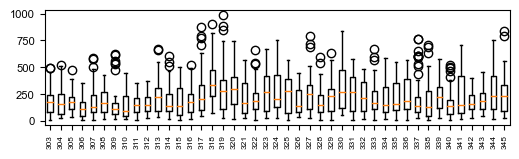

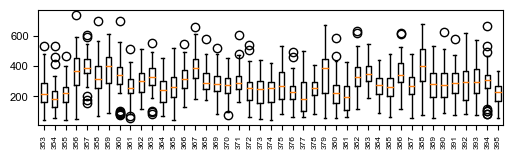

In [27]:
depth_list_1 = list ()
depth_list_2 = list ()
for i in range (npos) :
    vals = n0_sing_1[i*nAA:(i*nAA + nAA),:]
    depth_list_1.append (cp.deepcopy (vals[~np.isnan (vals)]))
    
    vals = n0_sing_2[i*nAA:(i*nAA + nAA),:]
    depth_list_2.append (cp.deepcopy (vals[~np.isnan (vals)]))
    
plt.rcParams["figure.figsize"] = (6,1.5)

plt.boxplot (depth_list_1)
plt.xticks ( np.arange (1,npos+1,1),
             np.arange (303,303+npos,1), rotation=90, size=6)
plt.show ()

plt.boxplot (depth_list_2)
plt.xticks ( np.arange (1,npos+1,1),
             np.arange (353,353+npos,1), rotation=90, size=6)
plt.show ()

In [28]:
# label T-2,372; T-2,330; S-1,342
focaldict    = dict ()

# label T-2,372; T-2,330; S-1,342; S-1,345
focal_1 = [(5,330-start_1),(6,342-start_1)]#,(6,345-start_1)]
focal_2 = [(5,372-start_2)]

focaldict[0] = dict ()
focaldict[0]['pairs']     = focal_1
focaldict[0]['pdz_aas']   = [14, 16]
focaldict[0]['cript_aas'] = [18, 19]

focaldict[1] = dict ()
focaldict[1]['pairs']     = focal_2
focaldict[1]['pdz_aas']  = [18]
focaldict[1]['cript_aas'] = [16]

In [29]:
plt.rcParams["figure.figsize"] = (3.5*.95,3.)

# spectral color map
maxval = 1
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)

fig, axs = plt.subplots (3, 3, height_ratios=[.65,2,2],
                         sharex='row', sharey='row', constrained_layout=True)

maxval = np.nanmax (np.abs (Dsyms))
bins   = np.linspace (-maxval, maxval, 20)

count = 0
for idx in range (2) :
    focal_pairs = cp.deepcopy (focaldict[idx]['pairs'])
    focal_aas   = cp.deepcopy (focaldict[idx]['cript_aas'])
    pdz_aas     = cp.deepcopy (focaldict[idx]['pdz_aas'])

    if idx == 0 :
        metaP = cp.deepcopy (meta_P1)
        start = 303
    else :
        metaP = cp.deepcopy (meta_P2)        
        start = 353
    Dmean = np.nanmean (Dsyms[idx,:,:,:], axis=2)
    Dsign = np.nanmean (Dsyms[idx,:,:,:], axis=2)
    Dsign[Dmean < 0] = -1
    Dsign[Dmean > 0] = 1
    Dsign[metaP > .1] = np.nan

    avgSign = np.zeros ((ncript, npos))
    for i in range (ncript) :
        for j in range (npos) :
            avgSign[i,j] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

    ct = 0
    for pair in focaldict[idx]['pairs'] :
        j_i, f_i = cp.deepcopy (pair)
        aa_i     = focaldict[idx]['pdz_aas'][ct]   # pdz aa
        aalig_i  = focaldict[idx]['cript_aas'][ct] # ligand aa

        # (1) Plot D values
        axs[0,count].hist ( np.ndarray.flatten (Dmean[j_i*nAA:(j_i*nAA + nAA),:][:,f_i*nAA:(f_i*nAA + nAA)]),
                          bins=bins, color=spec( norm (avgSign[j_i,f_i])),
                          edgecolor='black', linewidth=.2)
        axs[0,count].axvline (0, color='gray', linestyle='dashed', linewidth=.2)                
        axs[0,count].tick_params(axis='both', which='major', labelsize=6)
        #mylabel = r'avg. $D$'
        mylabel = r'$\bar D_{i(k),j(\ell)}$'

        axs[0,count].set_title (lig_labels[j_i] + ', ' + pdz_wt_full[f_i + 50*idx] + str (f_i + start),
                                fontsize=8)
        axs[0,count].set_xlabel (mylabel, labelpad=0, fontsize=8)
        
        if count == 0 :
            axs[0,count].set_ylabel (r'Count', labelpad=0)
            axs[0,count].set_yticks (np.arange (0,101,50),
                                   np.array (np.arange (0,101,50), dtype=int))
        # axis parameters
        axs[0,count].locator_params(axis='x', nbins=5)
        axs[0,count].tick_params (length=2)
        axs[0,count].xaxis.set_tick_params (pad=2)
        axs[0,count].yaxis.set_tick_params (pad=1.5)
        
        count += 1
        ct += 1
        
# spectral color map
maxval = 1
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)
maxval = np.nanmax (np.abs (Dsyms))
bins   = np.linspace (-maxval, maxval, 20)

count = 0
for idx in range (2) :
    focal_pairs = cp.deepcopy (focaldict[idx]['pairs'])
    focal_aas   = cp.deepcopy (focaldict[idx]['cript_aas'])
    pdz_aas     = cp.deepcopy (focaldict[idx]['pdz_aas'])
    
    # meta p-value and compute average single ranks
    if idx == 0 :
        metaP = cp.deepcopy (meta_P1)        
        y_rank = np.zeros_like (ysing_1)
        for i in range (nreps) :
            y_rank[:,i] = compute_mean_ranks (ysing_1[:,i])
            
        lig_rank = np.zeros_like (lsing_1)
        for i in range (nreps) :
            lig_rank[:,i] = compute_mean_ranks (lsing_1[:,i])
            
        start = 303
    else :
        metaP = cp.deepcopy (meta_P2)        
        y_rank = np.zeros_like (ysing_2)
        for i in range (nreps) :
            y_rank[:,i] = compute_mean_ranks (ysing_2[:,i])
            
        lig_rank = np.zeros_like (lsing_2)
        for i in range (nreps) :
            lig_rank[:,i] = compute_mean_ranks (lsing_2[:,i])
        start = 353

    

    Dmean  = np.nanmean (Dsyms[idx,:,:,:], axis=2)
    Rmean  = np.nanmean (Rmats[idx,:,:,:], axis=2)
    RLmean = np.nanmean (RLmats[idx,:,:,:], axis=2)
    Ymean  = np.nanmean (y_rank, axis=1)
    Lmean  = np.nanmean (lig_rank, axis=1)

    identity     = np.linspace (0, np.nanmax (Ymean), 20)
    identity_lig = np.linspace (0, np.nanmax (Lmean), 20)
    
    Davg = np.nanmean (Dsyms[idx,:,:,:], axis=2)
    Dsign = cp.deepcopy (Davg)
    Dsign[Davg < 0] = -1
    Dsign[Davg > 0] = 1
    Dsign[metaP > .1] = np.nan

    avgSign = np.zeros ((ncript, npos))
    for i in range (ncript) :
        for j in range (npos) :
            avgSign[i,j] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

    ct = 0
    for pair in focaldict[idx]['pairs'] :
        j_i, f_i = cp.deepcopy (pair)
        aa_i     = focaldict[idx]['pdz_aas'][ct]   # pdz aa
        aalig_i  = focaldict[idx]['cript_aas'][ct] # ligand aa
        
        # (2) Plot ligand ranks
        gray = axs[1,count].scatter (Lmean, RLmean[:,f_i*nAA + aa_i], c=metaP[:,f_i*nAA + aa_i], cmap='gray',
                                     norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                                     alpha=1., edgecolor='black', linewidth=.1, s=5)

        pink = axs[1,count].scatter (Lmean[j_i*nAA:(j_i*nAA + nAA)],
                                     RLmean[ j_i*nAA:(j_i*nAA + nAA), f_i*nAA + aa_i],
                                     edgecolor=spec( norm (avgSign[j_i,f_i]) ),
                                     cmap='gray', c=metaP[j_i*nAA:(j_i*nAA + nAA),f_i*nAA + aa_i],
                                     norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                                     alpha=1., linewidth=.3, s=10)
                
        # add annotations for the focal site
        for j in range (nAA) :
            if ~np.isnan (metaP[j_i*nAA + j,f_i*nAA + aa_i]) :
                axs[1,count].annotate ( aas[j], (Lmean[j_i*nAA + j]+5, RLmean[ j_i*nAA + j, f_i*nAA + aa_i,]+5),
                                       fontsize=6, color='black', zorder=1)#color=spec( norm (avgsign)))

                ymin_j = np.nanmin ([RLmean[ j_i*nAA + j, f_i*nAA + aa_i], Lmean[j_i*nAA + j]])
                ymax_j = np.nanmax ([RLmean[ j_i*nAA + j, f_i*nAA + aa_i], Lmean[j_i*nAA + j]])
                vals   = np.linspace (ymin_j, ymax_j, 10)

                axs[1,count].plot ( np.repeat (Lmean[j_i*nAA + j], 10), vals, linestyle='dashed',
                                  color=spec( norm (avgSign[j_i,f_i])), linewidth=.3)

        
        axs[1,count].plot ( identity_lig, identity_lig, linewidth=.5, linestyle='--', color='black')
        axs[1,count].set_xticks ( np.arange (0,np.nanmax (Lmean)+1,50),
                                  np.array (np.arange (0,np.nanmax (Lmean)+1,50), dtype=int),
                                  rotation=0, fontsize=6)
        axs[1,count].set_yticks ( np.arange (0,np.nanmax (Lmean)+1,50),
                                  np.array (np.arange (0,np.nanmax (Lmean)+1,50), dtype=int),
                                  fontsize=6)

        # axis labels
        axs[1,count].set_xlabel (r'CRIPT $\bar R_{i(\ell)}$', labelpad=.5, fontsize=8)
        axs[1,count].locator_params(axis='x', nbins=5)
        axs[1,count].tick_params (length=2)
        axs[1,count].xaxis.set_tick_params (pad=2)
        axs[1,count].yaxis.set_tick_params (pad=1.5)
        
        axs[1,count].annotate (str (f_i + start) + '(' + aas[aa_i] + ')', (100,10), fontsize=6)
        
        if count == 0 :
            axs[1,count].set_ylabel (r'$\bar R_{j(k),i(\ell)}$', labelpad=0)

        
        count += 1
        ct += 1
        
## ROW 3
# spectral color map
maxval = 1
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)

maxval = np.nanmax (np.abs (Dsyms))
bins   = np.linspace (-maxval, maxval, 20)

count = 0
for idx in range (2) :
    focal_pairs = cp.deepcopy (focaldict[idx]['pairs'])
    focal_aas   = cp.deepcopy (focaldict[idx]['cript_aas'])
    pdz_aas     = cp.deepcopy (focaldict[idx]['pdz_aas'])
    
    # meta p-value and compute average single ranks
    if idx == 0 :
        metaP = cp.deepcopy (meta_P1)        
        y_rank = np.zeros_like (ysing_1)
        for i in range (nreps) :
            y_rank[:,i] = compute_mean_ranks (ysing_1[:,i])
            
            
        lig_rank = np.zeros_like (lsing_1)
        for i in range (nreps) :
            lig_rank[:,i] = compute_mean_ranks (lsing_1[:,i])
    else :
        metaP = cp.deepcopy (meta_P2)        
        y_rank = np.zeros_like (ysing_2)
        for i in range (nreps) :
            y_rank[:,i] = compute_mean_ranks (ysing_2[:,i])
            
        lig_rank = np.zeros_like (lsing_2)
        for i in range (nreps) :
            lig_rank[:,i] = compute_mean_ranks (lsing_2[:,i])


    Dmean  = np.nanmean (Dsyms[idx,:,:,:], axis=2)
    Rmean  = np.nanmean (Rmats[idx,:,:,:], axis=2)
    RLmean = np.nanmean (RLmats[idx,:,:,:], axis=2)
    Ymean  = np.nanmean (y_rank, axis=1)
    Lmean  = np.nanmean (lig_rank, axis=1)

    identity     = np.linspace (0, np.nanmax (Ymean), 20)
    identity_lig = np.linspace (0, np.nanmax (Lmean), 20)
    
    Davg = np.nanmean (Dsyms[idx,:,:,:], axis=2)
    Dsign = cp.deepcopy (Davg)
    Dsign[Davg < 0] = -1
    Dsign[Davg > 0] = 1
    Dsign[metaP > .1] = np.nan

    avgSign = np.zeros ((ncript, npos))
    for i in range (ncript) :
        for j in range (npos) :
            avgSign[i,j] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

    ct = 0
    for pair in focaldict[idx]['pairs'] :
        j_i, f_i = cp.deepcopy (pair)
        aa_i     = focaldict[idx]['pdz_aas'][ct]   # pdz aa
        aalig_i  = focaldict[idx]['cript_aas'][ct] # ligand aa
        
        # (3) Plot pdz ranks
        gray = axs[2,count].scatter (Ymean, Rmean[j_i*nAA + aalig_i,:], c=metaP[j_i*nAA + aalig_i,:], cmap='gray',
                                     norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                                     alpha=1., edgecolor='black', linewidth=.1, s=5) 

        pink = axs[2,count].scatter (Ymean[f_i*nAA:(f_i*nAA + nAA)],
                                     Rmean[j_i*nAA + aalig_i, f_i*nAA:(f_i*nAA + nAA)],
                                     edgecolor=spec( norm (avgSign[j_i,f_i])),
                                     cmap='gray', c=metaP[j_i*nAA + aalig_i,f_i*nAA:(f_i*nAA + nAA)],
                                     norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                                     alpha=1., linewidth=.3, s=10)
        offsetx = 0
        offsety = 0
        for j in range (nAA) :
                if ~np.isnan (metaP[j_i*nAA + aalig_i,f_i*nAA + j]) :
                    if count == 2 and Rmean[j_i*nAA + aalig_i,f_i*nAA + j] > 700 :
                        offsetx = np.random.uniform (-50,50)
                        offsety = np.random.uniform (-50,-20)

                        
                    axs[2,count].annotate ( aas[j],
                                         (Ymean[f_i*nAA + j] + offsetx,
                                          Rmean[j_i*nAA + aalig_i,f_i*nAA + j] + offsety),
                                          fontsize=6, color='black', zorder=1)#color=spec( norm (avgsign)))

                    ymin_j = np.nanmin ([Rmean[j_i*nAA + aalig_i, f_i*nAA + j], Ymean[f_i*nAA + j]])
                    ymax_j = np.nanmax ([Rmean[j_i*nAA + aalig_i, f_i*nAA + j], Ymean[f_i*nAA + j]])
                    vals = np.linspace (ymin_j, ymax_j, 10)

                    axs[2,count].plot ( np.repeat (Ymean[f_i*nAA + j], 10), vals, linestyle='dashed',
                                        color=spec( norm (avgSign[j_i,f_i])), linewidth=.3 )

        axs[2,count].plot ( identity, identity, linewidth=.5, linestyle='--', color='black')
        axs[2,count].set_xticks ( np.arange (0,np.nanmax (Ymean)+1,200),
                                  np.array (np.arange (0,np.nanmax (Ymean)+1,200), dtype=int),
                                  rotation=0, fontsize=6)
        axs[2,count].set_yticks ( np.arange (0,np.nanmax (Ymean)+1,200),
                                  np.array (np.arange (0,np.nanmax (Ymean)+1,200), dtype=int),
                                  fontsize=6)

        # axis labels and parameters
        axs[2,count].set_xlabel (r'PDZ3 $\bar R_{j(\ell)}$', labelpad=.5, fontsize=8)
        axs[2,count].locator_params(axis='x', nbins=5)
        axs[2,count].tick_params (length=2)
        axs[2,count].xaxis.set_tick_params (pad=2)
        axs[2,count].yaxis.set_tick_params (pad=1.5)
        if count == 0 :
            axs[2,count].set_ylabel (r'$\bar R_{i(k),j(\ell)}$', labelpad=.5, fontsize=8)

        axs[2,count].annotate (lig_labels[j_i] + '(' + aas[aalig_i] + ')', (600,10), fontsize=6)
        
        count += 1
        ct += 1


if save :
    plt.savefig ( os.path.join (outdir, 'fig4_i_all.svg'),
                  bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/660617447.py:26: RuntimeWarning: Mean of empty slice
  Dmean = np.nanmean (Dsyms[idx,:,:,:], axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/660617447.py:27: RuntimeWarning: Mean of empty slice
  Dsign = np.nanmean (Dsyms[idx,:,:,:], axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/660617447.py:107: RuntimeWarning: Mean of empty slice
  Dmean  = np.nanmean (Dsyms[idx,:,:,:], axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/660617447.py:108: RuntimeWarning: Mean of empty slice
  Rmean  = np.nanmean (Rmats[idx,:,:,:], axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/660617447.py:109: RuntimeWarning: Mean of empty slice
  RLmean = np.nanmean (RLmats[idx,:,:,:], axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/660617447.py:110: RuntimeWarning: Mean of empty slice
  Ymean  = np.nanmean (y_rank, axis=1)
/var/folder

In [30]:
np.nanmin (metaP)

8.270715272706841e-05

In [31]:
plt.rcParams["figure.figsize"] = (1.5,1.5)

fig, ax = plt.subplots ()
gray = ax.scatter (Lmean, RLmean[:,0], c=metaP[:,0], cmap='gray',
                             norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                             alpha=1., edgecolor='black', linewidth=.1, s=5)
cbar = fig.colorbar (gray, ax=ax, shrink=0.5, aspect=13)
cbar.set_label ( r'meta $p$-value, $\tilde p_{ij}$', labelpad=6, size=6)
cbar.set_ticks (np.logspace (-4, 0, 3))
cbar.ax.tick_params (labelsize=6, length=3, pad=1)


if save :
    plt.savefig ( os.path.join (outdir, 'fig4_e_colorbar.svg'),
                  bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [32]:
Rmats_1  = np.zeros_like (ydoub_1)
Rmats_2  = np.zeros_like (ydoub_2)
y_rank_1 = np.zeros_like (ysing_1)
y_rank_2 = np.zeros_like (ysing_2)
Rlmats_1 = np.zeros_like (np.transpose (ydoub_1, axes=(1,0,2)))
Rlmats_2 = np.zeros_like (np.transpose (ydoub_2, axes=(1,0,2)))
lig_rank_1 = np.zeros_like (lsing_1)
lig_rank_2 = np.zeros_like (lsing_2)
for i in range (nreps) :
    Rmats_1[:,:,i]     = compute_transformed_Rmat (ydoub_1[:,:,i], M=np.sum (~np.isnan (ysing_1[:,i])) - 1)
    Rlmats_1[:,:,i]    = compute_transformed_Rmat (np.transpose (ydoub_1[:,:,i]), M=np.sum (~np.isnan (lsing_1[:,i])) - 1)
    Rmats_2[:,:,i]     = compute_transformed_Rmat (ydoub_2[:,:,i], M=np.sum (~np.isnan (ysing_2[:,i])) - 1)
    Rlmats_2[:,:,i]    = compute_transformed_Rmat (np.transpose (ydoub_2[:,:,i]), M=np.sum (~np.isnan (lsing_2[:,i])) - 1)
    y_rank_1[:,i]      = compute_mean_ranks (ysing_1[:,i])
    y_rank_2[:,i]      = compute_mean_ranks (ysing_2[:,i])

    lig_rank_1[:,i]      = compute_mean_ranks (lsing_1[:,i])
    lig_rank_2[:,i]      = compute_mean_ranks (lsing_2[:,i])


In [33]:
if (6,345-start_1) not in focaldict[0]['pairs'] :
    focaldict[0]['pairs'].append ((6,345-start_1))

In [34]:
plt.rcParams["figure.figsize"] = (3,3)

alpha = .01
for idx in range (2) :
    
    #alpha = alpha_enrich[idx,0]
    
    focal_pairs = cp.deepcopy (focaldict[idx]['pairs'])
    start = [start_1, start_2][idx]
    offset = [0,50][idx]
    
    if idx == 0 :
        metaP = cp.deepcopy (meta_P1)
        ymean = 10**np.nanmean (np.log10 (ysing_1), axis=1)
        yrank = np.nanmean (y_rank_1, axis=1)
        ydoub = 10**np.nanmean ( np.log10 (ydoub_1), axis=2)
        y_wt  = 10**np.nanmean (np.log10 ( (n1_wt_1 + 1) / (n0_wt_1 + 1)))
        
        lrank = np.nanmean (lig_rank_1, axis=1)
        lmean = np.nanmean (lsing_1, axis=1)


        print (y_wt)
    else :
        metaP = cp.deepcopy (meta_P2)
        ymean = 10**np.nanmean (np.log10 (ysing_2), axis=1)
        yrank = np.nanmean (y_rank_2, axis=1)
        ydoub = 10**np.nanmean ( np.log10 (ydoub_2), axis=2)
        y_wt  = 10**np.nanmean (np.log10 ( (n1_wt_2 + 1) / (n0_wt_2 + 1)))
        print (y_wt)
        
        lrank = np.nanmean (lig_rank_2, axis=1)
        lmean = np.nanmean (lsing_2, axis=1)

    Dmean  = np.nanmean (Dsyms[idx,:,:,:], axis=2)
    for i in focal_pairs :
        l2 = i[1]
        l1 = i[0]
        print ((l1, l2))
        
        # AA X AA
        plt.rcParams["figure.figsize"] = (3,3)

        fig, ax = plt.subplots ()
        maxval = np.nanmax (np.abs (Dmean[l1*nAA:(l1*nAA + nAA-1),:][:,l2*nAA:(l2*nAA + nAA-1)]))
        daa    = ax.imshow (Dmean[l1*nAA:(l1*nAA + nAA-1),:][:,l2*nAA:(l2*nAA + nAA-1)], vmin=-maxval, vmax=maxval,
                         cmap='Spectral')
        fig.colorbar (daa, ax=ax, shrink=0.6, label=r'$\hat D_{ij}$')

        print ('alpha: ' + str (alpha))
        x, y = np.where (metaP[l1*nAA:(l1*nAA + nAA-1),:][:,l2*nAA:(l2*nAA + nAA-1)] <= alpha)
        for i in range (len (x)) :
            ax.add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=False,lw=1.))# label=r'$\leq 5\AA$')
            
        x, y = np.where (metaP[l1*nAA:(l1*nAA + nAA-1),:][:,l2*nAA:(l2*nAA + nAA-1)] <= alpha*10)
        for i in range (len (x)) :
            ax.add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=False,lw=.5, linestyle='dotted'))# label=r'$\leq 5\AA$')
        
        x, y = np.where (ydoub[l1*nAA:(l1*nAA + nAA-1),:][:,l2*nAA:(l2*nAA + nAA-1)] >= y_wt)
        for i in range (len (x)) :
            ax.scatter (y[i], x[i], s=.5, color='dimgray')
        
        ax.tick_params (length=2)
        ax.xaxis.set_tick_params (pad=2)
        ax.yaxis.set_tick_params (pad=1.5)
        plt.xticks (np.arange (0,nAA-1,1), aas[:-1], fontsize=6)
        plt.yticks (np.arange (0,nAA-1,1), aas[:-1], fontsize=6)
        plt.ylabel ('CRIPT ' + lig_labels[l1])
        plt.xlabel ('PDZ ' + pdz_wt_full[l2+offset] + str (l2+start))

        if save :
            plt.savefig ( os.path.join (outdir, str (l2+start) + '_' + str (l1) + '.pdf'),
                         bbox_inches='tight',  dpi=600)
            plt.close ()
        else :
            plt.show ()
            
        

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:14: RuntimeWarning: Mean of empty slice
  ymean = 10**np.nanmean (np.log10 (ysing_1), axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:15: RuntimeWarning: Mean of empty slice
  yrank = np.nanmean (y_rank_1, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:16: RuntimeWarning: Mean of empty slice
  ydoub = 10**np.nanmean ( np.log10 (ydoub_1), axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:19: RuntimeWarning: Mean of empty slice
  lrank = np.nanmean (lig_rank_1, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:20: RuntimeWarning: Mean of empty slice
  lmean = np.nanmean (lsing_1, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:35: RuntimeWarning: Mean of empty slice
  Dmean  = np.nanmean (Dsyms[idx,:,:,:], axis=2)


2.796837156628841
(5, 27)
alpha: 0.01
(6, 39)
alpha: 0.01
(6, 42)
alpha: 0.01


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:26: RuntimeWarning: Mean of empty slice
  ymean = 10**np.nanmean (np.log10 (ysing_2), axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:27: RuntimeWarning: Mean of empty slice
  yrank = np.nanmean (y_rank_2, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:28: RuntimeWarning: Mean of empty slice
  ydoub = 10**np.nanmean ( np.log10 (ydoub_2), axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:32: RuntimeWarning: Mean of empty slice
  lrank = np.nanmean (lig_rank_2, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:33: RuntimeWarning: Mean of empty slice
  lmean = np.nanmean (lsing_2, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1949186922.py:35: RuntimeWarning: Mean of empty slice
  Dmean  = np.nanmean (Dsyms[idx,:,:,:], axis=2)


5.70900248414204
(5, 19)
alpha: 0.01


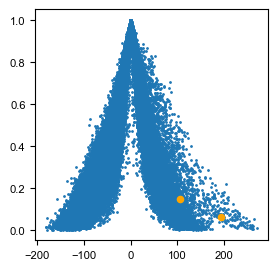

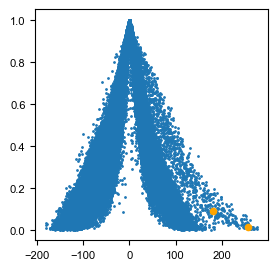

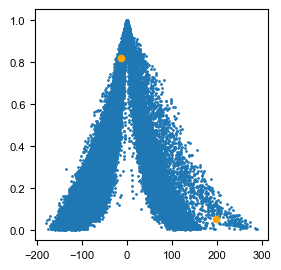

R
0.012968053574093807
[0.06393606 0.09190809 0.05294705]
[0.36363636 0.29166667 0.24242424]
[32. 23. 32.]
[11.  6.  7.]

0.012968053574093807
K
0.04156026201026608
[0.14585415 0.01198801 0.82017982]
[0.11538462 0.8125     0.02631579]
[25. 31. 37.]
[ 2. 25.  0.]

0.04156026201026608
34.734728357618515
9982
36.12277316397981
8271
27.565419584912934
11164


In [35]:
widxs = [x for x in range (len (aas)) if aas[x] in ['R','K']]
tlidx = [x for x in range (len (aas)) if aas[x] in ['V']]

for r in range (nreps) :
    plt.scatter (Dsyms[1,:,:,r], Pvals[1,:,:,r], s=1)

    for i in range (2) :
        plt.scatter (Dsyms[1,5*nAA + widxs[i],19*nAA + tlidx[0],r],
                     Pvals[1,5*nAA + widxs[i],19*nAA + tlidx[0],r], s=20, color='orange')
    plt.show ()


for i in range (2) :
    print (aas[widxs[i]])
    print (meta_P2[5*nAA + widxs[i],19*nAA + tlidx[0]])
    print (Pvals[1,5*nAA + widxs[i],19*nAA + tlidx[0],:])
    print (ydoub_2[5*nAA + widxs[i],19*nAA + tlidx[0]])
    print (n0_doub_2[5*nAA + widxs[i],19*nAA + tlidx[0]])
    print (n1_doub_2[5*nAA + widxs[i],19*nAA + tlidx[0]])
    print ()
    
    mp = -2*np.sum (np.log (Pvals[1,5*nAA + widxs[i],19*nAA + tlidx[0],:]) )
    print (1-scipy.stats.chi2.cdf (mp, df=2*3))
    
for i in range (nreps) :
    print (np.nanmean (n1_doub_2[:,:,i]))
    print (np.sum (n1_doub_2[:,:,i] == 0))


In [36]:
Eplus_2, Eplustot_2 = compute_enrichment (meta_P2, alpha=alpha_enrich[1,0],
                                          positive=True, Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))

print ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/880018153.py:2: RuntimeWarning: Mean of empty slice
  positive=True, Sign=np.nanmean (Dsyms[1,:,:,:], axis=2))


In [37]:
for r in range (nreps) :
    E_r, T_r = compute_enrichment (Pvals[1,:,:,r], alpha=.1, positive=True, Sign=Dsyms[1,:,:,r])
    for k in focaldict[1]['pairs'] :
        print (T_r[k[0],k[1]])
        
E_r, T_r = compute_enrichment (meta_P2, alpha=alpha_enrich[1,0], positive=True, Sign=Dsyms[1,:,:,r])
for k in focaldict[1]['pairs'] :
    print (T_r[k[0],k[1]])

53.0
73.0
78.0
53.0


In [38]:
n0_doub = np.column_stack ([n0_doub_1, n0_doub_2])
n1_doub = np.column_stack ([n1_doub_1, n1_doub_2])
ysing   = np.row_stack ([ysing_1, ysing_2])
lsing   = np.row_stack ([lsing_1, lsing_2])

In [39]:
lsing.shape

(336, 3)

In [40]:
Llig, L, nreps = n0_doub.shape
nlig = int (Llig / nAA)
npos = int (L / nAA)
print (L)

1806


In [41]:
# Y estimates without pseudo counts
Ydreads = (n1_doub / n0_doub)
Ydmean  = np.nanmean (Ydreads, axis=2)

# maximum number of observations in a given background
M = np.max (np.sum (~np.isnan (Ydreads), axis=0))
print (M)

154


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/732080362.py:3: RuntimeWarning: Mean of empty slice
  Ydmean  = np.nanmean (Ydreads, axis=2)


In [42]:
lsing_1.shape

(168, 3)

In [43]:
# compute residuals wrt rbar
y_rank          = np.zeros_like (ysing)
lig_rank_1      = np.zeros_like (lsing_1)
lig_rank_2      = np.zeros_like (lsing_2)
rbar_rank       = np.zeros_like (ysing)
rbar_lig_rank_1 = np.zeros_like (lsing_1)
Rmats           = np.zeros ( (Llig, L, nreps) )
Rlmats          = np.zeros ( (L, Llig, nreps) )
for i in range (nreps) :
    Rmats[:,:,i]       = compute_transformed_Rmat (Ydreads[:,:,i], M=np.sum (~np.isnan (ysing[:,i])) - 1)
    Rlmats[:,:,i]      = compute_transformed_Rmat (np.transpose (Ydreads[:,:,i]), M=np.sum (~np.isnan (lsing[:,i])) - 1)
    y_rank[:,i]        = compute_mean_ranks (ysing[:,i])
    rbar_rank[:,i]     = compute_mean_ranks (np.nanmean (Rmats[:,:,i], axis=0))
    lig_rank_1[:,i]      = compute_mean_ranks (lsing_1[:,i])
    lig_rank_2[:,i]      = compute_mean_ranks (lsing_2[:,i])

    #rbar_lig_rank[:,i] = compute_mean_ranks (np.nanmean (Rlmats[:,:,i], axis=0))

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/4030595305.py:13: RuntimeWarning: Mean of empty slice
  rbar_rank[:,i]     = compute_mean_ranks (np.nanmean (Rmats[:,:,i], axis=0))


In [44]:
# average over rank matrices
Rmean   = np.nanmean (Rmats, axis=2)
Rmean_t = np.nanmean (Rlmats, axis=2)

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3354662924.py:2: RuntimeWarning: Mean of empty slice
  Rmean   = np.nanmean (Rmats, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3354662924.py:3: RuntimeWarning: Mean of empty slice
  Rmean_t = np.nanmean (Rlmats, axis=2)


In [45]:
L_b1 = ysing_1.shape[0]
L_b2 = ysing_2.shape[0]

blocks = np.repeat (['dimgray'], L_b1)
blocks = np.concatenate ( [blocks, np.repeat (['lightgray'], L_b2)] )
print (blocks)

['dimgray' 'dimgray' 'dimgray' ... 'lightgray' 'lightgray' 'lightgray']


In [46]:
plt.rcParams["figure.figsize"] = (4,3.75)

fig, axs = plt.subplots (2, 2, sharey=False, constrained_layout=True)

bins = np.linspace ( 0, np.nanmax (y_rank), 20)
axs[0,0].hist (np.nanmean (y_rank, axis=1)[:L_b1], bins=bins,
             color='dimgray', edgecolor='black', linewidth=0.05,label='$\leq 342$')
axs[0,0].hist (np.nanmean (y_rank, axis=1)[L_b1:], bins=bins,
             color='lightgray', edgecolor='black', alpha=0.5, linewidth=0.05, label='$\geq 353$')

axs[1,0].hist (np.nanmean (Rmean, axis=0)[:L_b1], bins=bins,
             color='dimgray', edgecolor='black', linewidth=0.05, label='303-342aa')
axs[1,0].hist (np.nanmean (Rmean, axis=0)[L_b1:], bins=bins,
             color='lightgray', edgecolor='black', alpha=0.5, linewidth=0.05, label='353-395aa')

for i in range (2) :
    axs[i,0].set_xticks ( np.arange (0, np.nanmax (y_rank), 500),
                    np.array (np.arange (0, np.nanmax (y_rank), 500), dtype=int))
    axs[i,0].set_xlabel ([r'$\bar{R}_{i}^{pdz}$', r'$\bar{R}_{ij}$'][i])
    axs[i,0].set_ylabel ('Count')
    
# COLUMN 2
maxval = np.nanmax ([np.nanmax (np.nanmean (n0_sing_1, axis=1)),
                     np.nanmax (np.nanmean (n0_sing_2, axis=1))])

bins = np.logspace ( np.log10 (10), np.log10 (maxval), 20)
axs[0,1].hist (np.nanmean (n0_sing_1, axis=1), bins=bins,
             color='dimgray', edgecolor='black', linewidth=0.05,label='$\leq 342$')
axs[0,1].hist (np.nanmean (n0_sing_2, axis=1), bins=bins,
             color='lightgray', edgecolor='black', alpha=0.5, linewidth=0.05, label='$\geq 353$')
axs[0,1].legend (handlelength=1, fontsize=10, frameon=False)

maxval = np.nanmax ([np.nanmax (np.nanmean (n0_doub_1, axis=2)),
                     np.nanmax (np.nanmean (n0_doub_2, axis=2))])

bins = np.logspace ( np.log10 (10), np.log10 (maxval), 20)
axs[1,1].hist (np.ndarray.flatten (np.nanmean (n0_doub_1, axis=2)), bins=bins,
             color='dimgray', edgecolor='black', linewidth=0.05, label='303-342aa')
axs[1,1].hist (np.ndarray.flatten (np.nanmean (n0_doub_2, axis=2)), bins=bins,
             color='lightgray', edgecolor='black', alpha=0.5, linewidth=0.05, label='353-395aa')

for i in range (2) :
    axs[i,1].set_xscale ('log')

axs[0,1].set_xlabel (r'$\bar{N}_{i}^0$') 
axs[1,1].set_xlabel (r'$\bar{N}_{ij}^0$') 

ct = 0
for i in range (2) :
    for j in range (2) :
        axs[i,j].set_title (['a','b','c','d'][ct], loc='left', fontweight='bold')
        ct += 1
    

if save :
    plt.savefig (os.path.join (outdir, 'batch_effects.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2576802826.py:6: RuntimeWarning: Mean of empty slice
  axs[0,0].hist (np.nanmean (y_rank, axis=1)[:L_b1], bins=bins,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2576802826.py:8: RuntimeWarning: Mean of empty slice
  axs[0,0].hist (np.nanmean (y_rank, axis=1)[L_b1:], bins=bins,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2576802826.py:11: RuntimeWarning: Mean of empty slice
  axs[1,0].hist (np.nanmean (Rmean, axis=0)[:L_b1], bins=bins,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2576802826.py:13: RuntimeWarning: Mean of empty slice
  axs[1,0].hist (np.nanmean (Rmean, axis=0)[L_b1:], bins=bins,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2576802826.py:23: RuntimeWarning: Mean of empty slice
  maxval = np.nanmax ([np.nanmax (np.nanmean (n0_sing_1, axis=1)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/2576802826.py:24: RuntimeWa

In [47]:
rbar_1 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rmats_1, axis=2), axis=0)),
                          M=np.nanmax (y_rank_1))
rbar_2 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rmats_2, axis=2), axis=0)),
                          M=np.nanmax (y_rank_2))
rbar_lig_1 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rlmats_1, axis=2), axis=0)),
                          M=np.nanmax (lig_rank_1))
rbar_lig_2 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rlmats_2, axis=2), axis=0)),
                          M=np.nanmax (lig_rank_2))

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1850474272.py:1: RuntimeWarning: Mean of empty slice
  rbar_1 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rmats_1, axis=2), axis=0)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1850474272.py:3: RuntimeWarning: Mean of empty slice
  rbar_2 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rmats_2, axis=2), axis=0)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1850474272.py:5: RuntimeWarning: Mean of empty slice
  rbar_lig_1 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rlmats_1, axis=2), axis=0)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1850474272.py:7: RuntimeWarning: Mean of empty slice
  rbar_lig_2 = transform_ranks (compute_mean_ranks (np.nanmean (np.nanmean (Rlmats_2, axis=2), axis=0)),


In [48]:
Dsign = cp.deepcopy (Dsyms)
Dsign[Dsyms > 0] = 1
Dsign[Dsyms < 0] = -1
print (Dsign.shape)

(2, 168, 903, 3)


In [49]:
plt.rcParams["figure.figsize"] = (1, 1)

fig, axs = plt.subplots ()

maxval = np.nanmax (y_rank_2)
hm = axs.scatter (compute_mean_ranks (np.nanmean (y_rank_2, axis=1)), rbar_2,
                  c=np.nanmean (np.nanmean (Dsign[1,:,:,:], axis=2), axis=0),
                  cmap='Spectral', vmin=-1, vmax=1, s=5,
                  edgecolor='black', linewidth=0.05) 
axs.set_xticks ( np.arange (0, maxval, 400), np.array (np.arange (0, maxval, 400), dtype=int))
axs.set_yticks ( np.arange (0, maxval, 400), np.array (np.arange (0, maxval, 400), dtype=int))
axs.plot (np.linspace (0, maxval, 400), np.linspace (0, maxval, 400),
          color='black', linestyle='dashed', linewidth=.5)
axs.set_xlabel (r'$\bar R_i^{pdz}$', labelpad=0, fontsize=7)
axs.tick_params (length=2, labelsize=6, pad=1)
axs.set_ylabel (r'Rank of $\bar R_{\cdot,i}$', labelpad=0, fontsize=7)

maxr = np.nanmax (compute_mean_ranks (np.nanmean (y_rank_2, axis=1)))

axs.annotate ('block ' + str (i+1), (.05*maxr,.9*np.nanmax (rbar_2)), size=6)


if save :
    plt.savefig (os.path.join (outdir, 'block_2_rank.svg'),
                 format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()
    
# CRIPT RANK
fig, axs = plt.subplots ()

maxval  = np.nanmax (lig_rank)
hm = axs.scatter (compute_mean_ranks (np.nanmean (lig_rank_2, axis=1)), rbar_lig_2,
                  c=np.nanmean (np.nanmean (Dsign[1,:,:,:], axis=2), axis=1),
                  cmap='Spectral', vmin=-1, vmax=1, s=5,
                  edgecolor='black', linewidth=0.05) 

axs.set_xticks ( np.arange (0, maxval, 50), np.array (np.arange (0, maxval, 50), dtype=int))
axs.set_yticks ( np.arange (0, maxval, 50), np.array (np.arange (0, maxval, 50), dtype=int))

maxr = np.nanmax (compute_mean_ranks (np.nanmean (lig_rank, axis=1)))

axs.plot (np.linspace (0, maxval, 50), np.linspace (0, maxval, 50),
             color='black', linestyle='dashed', linewidth=.5)
axs.annotate ('block ' + str (i+1), (.05*maxr,.9*np.nanmax ( rbar_lig_2)), size=6)
axs.set_xlabel (r'$\bar R_j^{cript}$', labelpad=0, fontsize=7)
axs.tick_params (length=2, labelsize=6, pad=1)
axs.set_xlim ( (-10,165))
axs.set_ylim ( (-10,165))
axs.set_ylabel (r'Rank of $\bar R_{\cdot,j}$', labelpad=0, fontsize=7)

if save :
    plt.savefig (os.path.join (outdir, 'block_2_ligand_rank.svg'),
                 format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3216097892.py:6: RuntimeWarning: Mean of empty slice
  hm = axs.scatter (compute_mean_ranks (np.nanmean (y_rank_2, axis=1)), rbar_2,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3216097892.py:7: RuntimeWarning: Mean of empty slice
  c=np.nanmean (np.nanmean (Dsign[1,:,:,:], axis=2), axis=0),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3216097892.py:18: RuntimeWarning: Mean of empty slice
  maxr = np.nanmax (compute_mean_ranks (np.nanmean (y_rank_2, axis=1)))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3216097892.py:34: RuntimeWarning: Mean of empty slice
  hm = axs.scatter (compute_mean_ranks (np.nanmean (lig_rank_2, axis=1)), rbar_lig_2,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3216097892.py:35: RuntimeWarning: Mean of empty slice
  c=np.nanmean (np.nanmean (Dsign[1,:,:,:], axis=2), axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/i

In [50]:
cors = np.zeros ((2, nreps))
for i in range (nreps) :
    rbar_i = compute_mean_ranks (np.nanmean (Rmats_1[:,:,i], axis=0))
    cors[0,i] = scipy.stats.spearmanr ( ysing_1[:,i], rbar_i, nan_policy='omit').statistic
    rbar_i = compute_mean_ranks (np.nanmean (Rmats_2[:,:,i], axis=0))
    cors[1,i] = scipy.stats.spearmanr ( ysing_2[:,i], rbar_i,
                                   nan_policy='omit').statistic
    for j in range (i+1,nreps) :
        print (scipy.stats.spearmanr ( np.ndarray.flatten (ydoub_1[:,:,i]),
                                       np.ndarray.flatten (ydoub_1[:,:,j]),
                                       nan_policy='omit'))
        
print ('\nSpearmans correlations between single and average double ranks:')
print (np.nanmean (cors, axis=1))

print ('\nSpearmans correlations for single mutants:')
for i in range (nreps) :
    for j in range (i+1,nreps) :
        vals_i = cp.deepcopy (ysing_2[:,i])
        vals_j = cp.deepcopy (ysing_2[:,j])
        print (scipy.stats.spearmanr (vals_i, vals_j, nan_policy='omit'))

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/744515421.py:3: RuntimeWarning: Mean of empty slice
  rbar_i = compute_mean_ranks (np.nanmean (Rmats_1[:,:,i], axis=0))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/744515421.py:5: RuntimeWarning: Mean of empty slice
  rbar_i = compute_mean_ranks (np.nanmean (Rmats_2[:,:,i], axis=0))


SignificanceResult(statistic=0.9362006511874119, pvalue=0.0)
SignificanceResult(statistic=0.9309486942559043, pvalue=0.0)
SignificanceResult(statistic=0.9370704425460419, pvalue=0.0)

Spearmans correlations between single and average double ranks:
[0.9197552  0.92527023]

Spearmans correlations for single mutants:
SignificanceResult(statistic=0.9124479973803046, pvalue=0.0)
SignificanceResult(statistic=0.8963702292894216, pvalue=2.6630957118746954e-298)
SignificanceResult(statistic=0.9135084248713626, pvalue=0.0)


In [51]:
plt.rcParams["figure.figsize"] = (3, 1.25)

fig, axs = plt.subplots (1,2, sharex=True, sharey=True, constrained_layout=True)

maxval  = np.nanmax ( [np.nanmax (y_rank_1), np.nanmax (y_rank_2)] )
minread = np.nanmin ( [np.nanmin (np.nanmean (n0_sing_1, axis=1)),
                       np.nanmin (np.nanmean (n0_sing_2, axis=1))])
maxread = np.nanmin ( [np.nanmax (np.nanmean (n0_sing_1, axis=1)),
                       np.nanmax (np.nanmean (n0_sing_2, axis=1))]) 

hm = axs[0].scatter (compute_mean_ranks (np.nanmean (y_rank_1, axis=1)), rbar_1,
                     c=np.nanmean (np.nanmean (Dsign[0,:,:,:], axis=2), axis=0),
                     cmap='Spectral', vmin=-1, vmax=1, s=5,
                     edgecolor='black', linewidth=0.01) #vmin=minread, vmax=maxread)
axs[1].scatter (compute_mean_ranks (np.nanmean (y_rank_2, axis=1)), rbar_2,
                c=np.nanmean (np.nanmean (Dsign[1,:,:,:], axis=2), axis=0),
                     cmap='Spectral', vmin=-1, vmax=1, s=5,
                     edgecolor='black', linewidth=0.01) 
cbar = fig.colorbar (hm, ax=axs[1], label=r'$\bar{sign}(\bar D_{ij})$')
cbar.ax.tick_params(labelsize=6) 

print (scipy.stats.spearmanr (compute_mean_ranks (np.nanmean (y_rank_1, axis=1)),  rbar_1,
                             nan_policy='omit'))
print (scipy.stats.spearmanr (compute_mean_ranks (np.nanmean (y_rank_2, axis=1)),  rbar_2,
                             nan_policy='omit'))

for i in range (2) :
    axs[i].set_xticks ( np.arange (0, maxval, 400), np.array (np.arange (0, maxval, 400), dtype=int))
    axs[i].set_yticks ( np.arange (0, maxval, 400), np.array (np.arange (0, maxval, 400), dtype=int))

    axs[i].plot (np.linspace (0, maxval, 400), np.linspace (0, maxval, 400),
                 color='black', linestyle='dashed', linewidth=1)
    axs[i].annotate ('block ' + str (i+1), (25,720))
    axs[i].set_xlabel (r'$\bar R_i^{pdz}$', labelpad=0)
    axs[i].tick_params (length=2)
    axs[i].yaxis.set_tick_params (pad=2)

axs[0].set_ylabel (r'Rank of $\bar R_{\cdot,i}^{pdz}$', labelpad=0)

if save :
    plt.savefig (os.path.join (outdir, 'single_cor.pdf'), bbox_inches='tight', dpi=600)
    plt.close ()
else :
    plt.show ()

SignificanceResult(statistic=0.9398514223651336, pvalue=0.0)
SignificanceResult(statistic=0.9514481422078259, pvalue=0.0)


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1979826339.py:6: RuntimeWarning: Mean of empty slice
  minread = np.nanmin ( [np.nanmin (np.nanmean (n0_sing_1, axis=1)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1979826339.py:7: RuntimeWarning: Mean of empty slice
  np.nanmin (np.nanmean (n0_sing_2, axis=1))])
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1979826339.py:8: RuntimeWarning: Mean of empty slice
  maxread = np.nanmin ( [np.nanmax (np.nanmean (n0_sing_1, axis=1)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1979826339.py:9: RuntimeWarning: Mean of empty slice
  np.nanmax (np.nanmean (n0_sing_2, axis=1))])
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1979826339.py:11: RuntimeWarning: Mean of empty slice
  hm = axs[0].scatter (compute_mean_ranks (np.nanmean (y_rank_1, axis=1)), rbar_1,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1979826339.py:12: RuntimeWarning: M

In [52]:
plt.rcParams["figure.figsize"] = (3, 1.25)

fig, axs = plt.subplots (1,2, sharex=True, sharey=True, constrained_layout=True)

maxval  = np.max ( [np.nanmax (lig_rank_1), np.nanmax (lig_rank_2)] )

hm = axs[0].scatter (compute_mean_ranks (np.nanmean (lig_rank_1, axis=1)), rbar_lig_1,
                     c=np.nanmean (np.nanmean (Dsign[0,:,:,:], axis=2), axis=1),
                     cmap='Spectral', vmin=-1, vmax=1, s=5,
                     edgecolor='black', linewidth=0.01) #vmin=minread, vmax=maxread)
axs[1].scatter (compute_mean_ranks (np.nanmean (lig_rank_2, axis=1)), rbar_lig_2,
                c=np.nanmean (np.nanmean (Dsign[1,:,:,:], axis=2), axis=1),
                     cmap='Spectral', vmin=-1, vmax=1, s=5,
                     edgecolor='black', linewidth=0.01) 
cbar = fig.colorbar (hm, ax=axs[1], label=r'$\bar{sign}(\bar D_{ij})$')
cbar.ax.tick_params(labelsize=6) 

for i in range (2) :
    axs[i].set_xticks ( np.arange (0, maxval, 50), np.array (np.arange (0, maxval, 50), dtype=int))
    axs[i].set_yticks ( np.arange (0, maxval, 50), np.array (np.arange (0, maxval, 50), dtype=int))

    axs[i].plot (np.linspace (0, maxval, 50), np.linspace (0, maxval, 50),
                 color='black', linestyle='dashed', linewidth=1)
    axs[i].annotate ('block ' + str (i+1), (5,130))
    axs[i].set_xlabel (r'$\bar R_i^{cript}$', labelpad=0)
    axs[i].tick_params (length=2)
    axs[i].yaxis.set_tick_params (pad=2)

axs[0].set_ylabel (r'Rank of $\bar R_{\cdot,i}$', labelpad=0)

if save :
    plt.savefig (os.path.join (outdir, 'single_ligand_cor.pdf'), bbox_inches='tight', dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/608567923.py:7: RuntimeWarning: Mean of empty slice
  hm = axs[0].scatter (compute_mean_ranks (np.nanmean (lig_rank_1, axis=1)), rbar_lig_1,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/608567923.py:8: RuntimeWarning: Mean of empty slice
  c=np.nanmean (np.nanmean (Dsign[0,:,:,:], axis=2), axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/608567923.py:11: RuntimeWarning: Mean of empty slice
  axs[1].scatter (compute_mean_ranks (np.nanmean (lig_rank_2, axis=1)), rbar_lig_2,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/608567923.py:12: RuntimeWarning: Mean of empty slice
  c=np.nanmean (np.nanmean (Dsign[1,:,:,:], axis=2), axis=1),


In [53]:
len (rbar_lig_1)

168

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/4105027124.py:5: RuntimeWarning: Mean of empty slice
  lig_residual_1 = rbar_lig_1 - compute_mean_ranks (np.nanmean (lig_rank_1, axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/4105027124.py:6: RuntimeWarning: Mean of empty slice
  lig_residual_2 = rbar_lig_2 - compute_mean_ranks (np.nanmean (lig_rank_2, axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/4105027124.py:10: RuntimeWarning: Mean of empty slice
  miny = np.nanmin (10**np.nanmean (np.log10 (lsing), axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/4105027124.py:11: RuntimeWarning: Mean of empty slice
  maxy = np.nanmax (10**np.nanmean (np.log10 (lsing), axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/4105027124.py:13: RuntimeWarning: Mean of empty slice
  myp = axs[0].scatter (np.nanmean (n0_cript_1, axis=1), lig_residual_1,
/var/folders/38/f4j79l017855c4b93219m3bh000

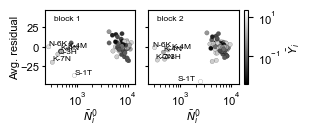

In [54]:
plt.rcParams["figure.figsize"] = (3, 1.25)

fig, axs = plt.subplots (1, 2, sharex=True, sharey=True, constrained_layout=True)

lig_residual_1 = rbar_lig_1 - compute_mean_ranks (np.nanmean (lig_rank_1, axis=1))
lig_residual_2 = rbar_lig_2 - compute_mean_ranks (np.nanmean (lig_rank_2, axis=1))

maxres = np.nanmax ([np.abs (lig_residual_1), np.abs (lig_residual_2)])

miny = np.nanmin (10**np.nanmean (np.log10 (lsing), axis=1))
maxy = np.nanmax (10**np.nanmean (np.log10 (lsing), axis=1))

myp = axs[0].scatter (np.nanmean (n0_cript_1, axis=1), lig_residual_1,
                      c=10**np.nanmean (np.log10 (lsing_1), axis=1),
                      cmap='gray', norm=mpl.colors.LogNorm (vmin=miny, vmax=maxy), edgecolor='black',
                      s=10, linewidth=.1)
xs = np.where ( np.logical_or (np.abs (lig_residual_1) > 20,np.nanmean (n0_cript_2, axis=1) < 1e3))[0]
for i in range (len (xs)) :
    xi = xs[i]
    axs[0].annotate (lig_labels[int (np.floor (xi / nAA))] + aas[xi % nAA],
                     (np.nanmean (n0_cript_1, axis=1)[xi]+2, lig_residual_1[xi]+2),
                     fontsize=6)

#fig.colorbar ()
axs[0].set_xscale ('log')


axs[1].scatter (np.nanmean (n0_cript_2, axis=1), lig_residual_2,
                c=10**np.nanmean (np.log10 (lsing_1), axis=1),
                cmap='gray', norm=mpl.colors.LogNorm (vmin=miny, vmax=maxy), edgecolor='black',
                s=10, linewidth=.1)
xs = np.where ( np.logical_or (np.abs (lig_residual_2) > 20,np.nanmean (n0_cript_2, axis=1) < 1e3))[0]
for i in range (len (xs)) :
    xi = xs[i]
    axs[1].annotate (lig_labels[int (np.floor (xi / nAA))] + aas[xi % nAA],
                  (np.nanmean (n0_cript_1, axis=1)[xi]+2, lig_residual_2[xi]+2), fontsize=6)

axs[0].set_ylabel ('Avg. residual', labelpad=0)
for i in range (2) :
    axs[i].set_xlabel (r'$\bar N_i^0$', labelpad=0)
    axs[i].tick_params (length=2)
    axs[i].yaxis.set_tick_params (pad=2)
    axs[i].xaxis.set_tick_params (pad=2)
    axs[i].set_ylim ((-maxres-3, maxres+2))
    axs[i].annotate ('block ' + str (i+1), (350, maxres-10), fontsize=6)

fig.colorbar (myp, ax=axs[-1], label=r'$\bar Y_i$')
plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1356333277.py:5: RuntimeWarning: Mean of empty slice
  residual_1 = rbar_1 - compute_mean_ranks (np.nanmean (y_rank_1, axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1356333277.py:6: RuntimeWarning: Mean of empty slice
  residual_2 = rbar_2 - compute_mean_ranks (np.nanmean (y_rank_2, axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1356333277.py:10: RuntimeWarning: Mean of empty slice
  miny = np.nanmin (10**np.nanmean (np.log10 (ysing_1), axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1356333277.py:11: RuntimeWarning: Mean of empty slice
  maxy = np.nanmax (10**np.nanmean (np.log10 (ysing_1), axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/1356333277.py:12: RuntimeWarning: Mean of empty slice
  miny = np.nanmin ( [miny, np.nanmin (10**np.nanmean (np.log10 (ysing_2), axis=1))])
/var/folders/38/f4j79l017855c4b93219m3bh0000gp

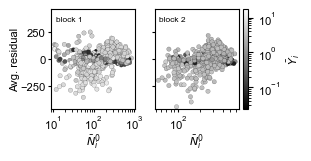

In [55]:
plt.rcParams["figure.figsize"] = (3, 1.5)

fig, axs = plt.subplots (1, 2, sharex=False, sharey=True, constrained_layout=True)

residual_1 = rbar_1 - compute_mean_ranks (np.nanmean (y_rank_1, axis=1))
residual_2 = rbar_2 - compute_mean_ranks (np.nanmean (y_rank_2, axis=1))

maxres = np.nanmax ([np.abs (residual_1), np.abs (residual_2)])

miny = np.nanmin (10**np.nanmean (np.log10 (ysing_1), axis=1))
maxy = np.nanmax (10**np.nanmean (np.log10 (ysing_1), axis=1))
miny = np.nanmin ( [miny, np.nanmin (10**np.nanmean (np.log10 (ysing_2), axis=1))])
maxy = np.nanmax ( [maxy, np.nanmax (10**np.nanmean (np.log10 (ysing_2), axis=1))])

myp = axs[0].scatter (np.nanmean (n0_sing_1, axis=1), residual_1,
                      c=10**np.nanmean (np.log10 (ysing_1), axis=1),
                      cmap='gray', norm=mpl.colors.LogNorm (vmin=miny, vmax=maxy), edgecolor='black',
                      s=10, linewidth=.1)

axs[1].scatter (np.nanmean (n0_sing_2, axis=1), residual_2,
                c=10**np.nanmean (np.log10 (ysing_2), axis=1),
                cmap='gray', norm=mpl.colors.LogNorm (vmin=miny, vmax=maxy), edgecolor='black',
                s=10, linewidth=.1)

axs[0].set_ylabel ('Avg. residual', labelpad=0)
for i in range (2) :
    axs[i].set_xlabel (r'$\bar N_i^0$', labelpad=0)
    axs[i].tick_params (length=2)
    axs[i].yaxis.set_tick_params (pad=2)
    axs[i].xaxis.set_tick_params (pad=2)
    axs[i].set_ylim ((-maxres-20, maxres+20))
    axs[i].set_xscale ('log')
    axs[i].annotate ('block ' + str (i+1), ([12,56][i], maxres-90), fontsize=6)

fig.colorbar (myp, ax=axs[-1], label=r'$\bar Y_i$')
plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3215576540.py:7: RuntimeWarning: invalid value encountered in divide
  axs[i].scatter (n0_sing_2[:,i], np.sum (Pvals[1,:,:,i] < .1, axis=0) / numtests, s=1)


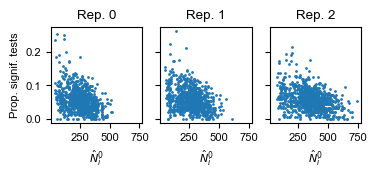

In [56]:
plt.rcParams["figure.figsize"] = (4, 1.25)

fig, axs = plt.subplots (1, 3, sharex=True, sharey=True)

for i in range (nreps) :
    numtests = np.sum (~np.isnan (Pvals[1,:,:,i]), axis=0)
    axs[i].scatter (n0_sing_2[:,i], np.sum (Pvals[1,:,:,i] < .1, axis=0) / numtests, s=1)
    axs[i].set_xlabel (r'$\hat N_i^0$')
    axs[i].set_title ('Rep. ' + str (i))
axs[0].set_ylabel ('Prop. signif. tests')
plt.show ()

In [57]:
plt.rcParams["figure.figsize"] = (4,4)

fig, axs = plt.subplots (2, 3, sharey='row', constrained_layout=True)

for i in range (nreps) :
    myp = axs[0,i].hexbin (n0_sing_1[:,i], np.nanmean (n0_doub_1[:,:,i], axis=0),
                           norm=mpl.colors.LogNorm (), cmap='Blues', gridsize=20)
    fig.colorbar (myp, ax=axs[0,i], location='top', shrink=0.75, aspect=10)
    
    myp = axs[1,i].hexbin (n0_sing_2[:,i], np.nanmean (n0_doub_2[:,:,i], axis=0),
                           norm=mpl.colors.LogNorm (), cmap='Purples', gridsize=20)
    fig.colorbar (myp, ax=axs[1,i], location='top', shrink=0.75, aspect=10)

    axs[1,i].set_xlabel (r'$\hat N_i^0$')
    #axs[0,i].set_title ('Rep. ' + str (i))
axs[0,0].set_ylabel (r'$\bar N_{ij}$')
axs[1,0].set_ylabel (r'$\bar N_{ij}$')

if save :
    plt.savefig (os.path.join (outdir, 'single_reads_blocks.pdf'), bbox_inches='tight', dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3485748835.py:6: RuntimeWarning: Mean of empty slice
  myp = axs[0,i].hexbin (n0_sing_1[:,i], np.nanmean (n0_doub_1[:,:,i], axis=0),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3485748835.py:10: RuntimeWarning: Mean of empty slice
  myp = axs[1,i].hexbin (n0_sing_2[:,i], np.nanmean (n0_doub_2[:,:,i], axis=0),


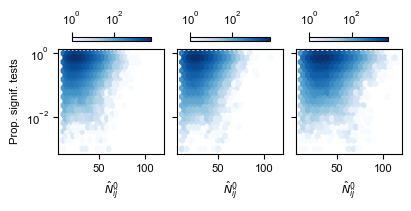

In [58]:
plt.rcParams["figure.figsize"] = (4, 2)

fig, axs = plt.subplots (1, 3, sharex=True, sharey=True, constrained_layout=True)

for i in range (nreps) :
    xvals = cp.deepcopy (n0_doub_2[:,:,i])
    yvals = cp.deepcopy (Pvals[1,:,:,i])
    myp = axs[i].hexbin (xvals[np.logical_and (~np.isnan (xvals), ~np.isnan (yvals))],
                   yvals[np.logical_and (~np.isnan (xvals), ~np.isnan (yvals))], yscale='log',
                   norm=mpl.colors.LogNorm (), cmap='Blues', gridsize=20)
    fig.colorbar (myp, ax=axs[i], location='top', shrink=0.75)
    axs[i].set_yscale ('log')
    axs[i].set_xlabel (r'$\hat N_{ij}^0$')
    #axs[i].set_title ('Rep. ' + str (i))
axs[0].set_ylabel ('Prop. signif. tests')
plt.show ()

In [59]:
plt.rcParams["figure.figsize"] = (3.5, 3.5)

fig, axs = plt.subplots (3,2, sharey=True, sharex='col',constrained_layout=True)

for i in range (nreps) :

    r_1 = compute_mean_ranks (np.nanmean (Rmats_1[:,:,i], axis=0))
    r_2 = compute_mean_ranks (np.nanmean (Rmats_2[:,:,i], axis=0))

    residuals_1 = transform_ranks (r_1, np.sum (~np.isnan (y_rank_1[:,i]))) - y_rank_1[:,i]
    residuals_2 = transform_ranks (r_2, np.sum (~np.isnan (y_rank_2[:,i]))) - y_rank_2[:,i]

    Dsign = cp.deepcopy (Dsyms[:,:,:,i])
    Dsign[Dsign > 0] = 1
    Dsign[Dsign < 0] = -1
    
    myp = axs[i,0].scatter (n0_sing_1[:,i], residuals_1,
                            c=np.nanmean (Dsign[0,:,:], axis=0), cmap='Spectral',
                            vmin=-1, vmax=1,
                            edgecolor='black', linewidth=.05, s=10)

    myp = axs[i,1].scatter (n0_sing_2[:,i], residuals_2,
                          c=np.nanmean (Dsign[1,:,:], axis=0), cmap='Spectral',
                            vmin=-1, vmax=1,
                          edgecolor='black', linewidth=.05, s=10)
    
    if i == 0 :
        for j in range (2) :
            axs[i,j].set_title (['block 1', 'block 2'][j])
            
    if i == 1 :
        fig.colorbar (myp, ax=axs[i,1], location='right', shrink=1, aspect=20, label=r'avg. sign $\hat D$')

    for j in range (2) :    
        axs[i,j].tick_params (length=2)
        axs[i,j].yaxis.set_tick_params (pad=2)
        axs[i,j].xaxis.set_tick_params (pad=2)
    
    axs[i,0].set_ylabel ('Rep ' + str (i+1) + ' residual')
    if i == 2 :
        for j in range (2) :
            axs[i,j].set_xlabel (r'$\hat N_i^0$')


if save :
    plt.savefig (os.path.join (outdir, 'n0_vs_res.pdf'), bbox_inches='tight', dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/287950395.py:7: RuntimeWarning: Mean of empty slice
  r_1 = compute_mean_ranks (np.nanmean (Rmats_1[:,:,i], axis=0))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/287950395.py:8: RuntimeWarning: Mean of empty slice
  r_2 = compute_mean_ranks (np.nanmean (Rmats_2[:,:,i], axis=0))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/287950395.py:18: RuntimeWarning: Mean of empty slice
  c=np.nanmean (Dsign[0,:,:], axis=0), cmap='Spectral',
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/287950395.py:23: RuntimeWarning: Mean of empty slice
  c=np.nanmean (Dsign[1,:,:], axis=0), cmap='Spectral',


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/981668310.py:1: RuntimeWarning: Mean of empty slice
  residuals   = rbar_1 - compute_mean_ranks (np.nanmean (y_rank_1, axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/981668310.py:2: RuntimeWarning: Mean of empty slice
  residuals_2 = rbar_2 - compute_mean_ranks (np.nanmean (y_rank_2, axis=1))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/981668310.py:6: RuntimeWarning: Mean of empty slice
  Davg = np.nanmean (Dsyms, axis=-1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/981668310.py:7: RuntimeWarning: Mean of empty slice
  myp = axs[0].scatter (np.nanmean (n0_sing_1, axis=1), residuals,
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/981668310.py:8: RuntimeWarning: Mean of empty slice
  c=np.nanmean (Davg[0,:,:], axis=0), cmap='Spectral',
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/981668310.py:12: RuntimeWarning: Mean of empt

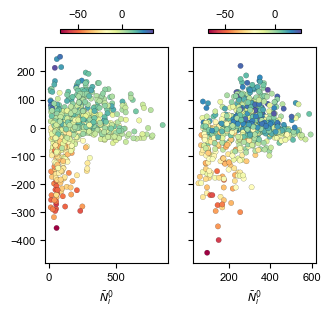

In [60]:
residuals   = rbar_1 - compute_mean_ranks (np.nanmean (y_rank_1, axis=1))
residuals_2 = rbar_2 - compute_mean_ranks (np.nanmean (y_rank_2, axis=1))

fig, axs = plt.subplots (1,2, sharey=True)

Davg = np.nanmean (Dsyms, axis=-1)
myp = axs[0].scatter (np.nanmean (n0_sing_1, axis=1), residuals,
                      c=np.nanmean (Davg[0,:,:], axis=0), cmap='Spectral',
                      edgecolor='black', linewidth=.1, s=15)
fig.colorbar (myp, ax=axs[0], location='top', shrink=0.75)

myp = axs[1].scatter (np.nanmean (n0_sing_2, axis=1), residuals_2,
                      c=np.nanmean (Davg[1,:,:], axis=0), cmap='Spectral',
                      edgecolor='black', linewidth=.1, s=15)
fig.colorbar (myp, ax=axs[1], location='top', shrink=0.75)

for i in range (len (axs)) :
    axs[i].set_xlabel (r'$\bar N_i^0$')
plt.show ()



In [61]:
plt.rcParams["figure.figsize"] = (4, 5)

fig, axs = plt.subplots (4,2, sharex='col', constrained_layout=True)

Dsign = np.nanmean (Dsyms, axis=-1)
Dsign[Dsign < 0] = -1
Dsign[Dsign > 0] = 1
Dsign[0, meta_P1 > .1] = np.nan
Dsign[1, meta_P2 > .1] = np.nan

axs[0,0].scatter (np.nanmean (n0_sing_1, axis=1),
                  np.sum (meta_P1 < .1, axis=0),
                  c=spec (norm (np.nanmean (Dsign[0,:,:], axis=0))),
                  s=10, edgecolor='black', linewidth=.1)
axs[0,1].scatter (np.nanmean (n0_sing_2, axis=1),
                  np.sum (meta_P2 < .1, axis=0),
                  c=spec (norm (np.nanmean (Dsign[1,:,:], axis=0))),
                  s=10, edgecolor='black', linewidth=.1)

idxs = np.where (np.sum (meta_P2 < .1, axis=0) > 19)[0]
for i in range (len (idxs)) :
    ii = int (idxs[i])
    axs[0,1].annotate ( pdz_wt_full[50 + int (ii/nAA)] + str (int (ii/nAA)+353) + aas[ii % nAA],
                       (np.nanmean (n0_sing_2, axis=1)[ii],
                          np.sum (meta_P2 < .1, axis=0)[ii]), fontsize=6)

idxs = np.where (np.sum (meta_P1 < .1, axis=0) > 25)[0]
for i in range (len (idxs)) :
    ii = int (idxs[i])
    axs[0,0].annotate ( pdz_wt_full[int (ii/nAA)] + str (int (ii/nAA)+303) + aas[ii % nAA],
                       (np.nanmean (n0_sing_1, axis=1)[ii],
                          np.sum (meta_P1 < .1, axis=0)[ii]),
                      fontsize=6) 
    
    
Dsign = cp.deepcopy (Dsyms)
Dsign[Dsyms < 0] = -1
Dsign[Dsyms > 0] = 1
Dsign[Pvals > .1] = np.nan
for i in range (nreps) :
    axs[i+1,0].scatter (n0_sing_1[:,i], np.sum (Pvals[0,:,:,i] < .1, axis=0),
                        c=spec (norm (np.nanmean (Dsign[0,:,:,i], axis=0))),
                        s=10, edgecolor='black', linewidth=.1)
    axs[i+1,1].scatter (n0_sing_2[:,i], np.sum (Pvals[1,:,:,i] < .1, axis=0),
                        c=spec (norm (np.nanmean (Dsign[1,:,:,i], axis=0))),
                       s=10, edgecolor='black', linewidth=.1)
for i in range (4) :
    axs[i,0].set_ylabel ('Count')
    
for i in range (2) :
    axs[0,i].set_xlabel (r'$\bar N_i^0$')
    axs[-1,i].set_xlabel (r'$N_i^0$ per replicate')

if save :
    plt.savefig (os.path.join (outdir, 'n0_vs_numsignif.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3538447425.py:5: RuntimeWarning: Mean of empty slice
  Dsign = np.nanmean (Dsyms, axis=-1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3538447425.py:11: RuntimeWarning: Mean of empty slice
  axs[0,0].scatter (np.nanmean (n0_sing_1, axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3538447425.py:13: RuntimeWarning: Mean of empty slice
  c=spec (norm (np.nanmean (Dsign[0,:,:], axis=0))),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3538447425.py:15: RuntimeWarning: Mean of empty slice
  axs[0,1].scatter (np.nanmean (n0_sing_2, axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3538447425.py:17: RuntimeWarning: Mean of empty slice
  c=spec (norm (np.nanmean (Dsign[1,:,:], axis=0))),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_5081/3538447425.py:24: RuntimeWarning: Mean of empty slice
  (np.nanmean (n0_sing_2, axis=1)[ii],
/var/f

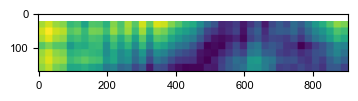

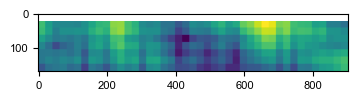

In [62]:
# recompute big distance matrix
bigDist = np.zeros ((2,Llig,L1)) * np.nan
for i in range (1,nlig) :
    bigDist[0,(i*nAA):(i*nAA + nAA),:] = np.reshape (np.repeat (Df_1[i-1,:], nAA**2), (nAA, L1), order='F')
    bigDist[1,(i*nAA):(i*nAA + nAA),:] = np.reshape (np.repeat (Df_2[i-1,:], nAA**2), (nAA, L2), order='F')

# plot to check
plt.imshow (bigDist[0,:,:])
plt.show ()

plt.imshow (bigDist[1,:,:])
plt.show ()

In [63]:
alpha_enrich

array([[0.03404087, 0.03404087],
       [0.02118678, 0.02118678]])

In [64]:
conmax   = .5
powermax = .35
fpmax    = .06

i = 0
for idx in range (2) :
    if idx == 0 :
        ys = cp.deepcopy (ysing_1[:,i])
        ls = cp.deepcopy (lsing_1[:,i])
    else :
        ys = cp.deepcopy (ysing_2[:,i])
        ls = cp.deepcopy (lsing_2[:,i])
    
    make_fpr_figure_individual (Pvals[idx,:,:,i], bigDist[idx,:,:],
                                Dsyms[idx,:,:,i],
                                ys, ls, 
                                ybinsize=50, lbinsize=20, alpha=.05,#alpha_enrich[i,0],
                                conmax=conmax, powermax=powermax, fpmax=fpmax, colorbar=False,
                                outlabel='block_' + str (idx+1) + '_' + str (i), save=save,
                                outdir=outdir, figsize=(1.25, 1.15),
                                llabel=r'$\hat Y_j^{cript}$', ylabel=r'$\hat Y_i^{pdz3}$')

(168, 903)
68346
68346
68346
0.5
0.4557595993322204
power:
0.2
0.05641592920353982
(168, 903)
30368
30368
30368
0.5
0.2735723771580345
power:
0.3333333333333333
0.038623005877413935


/Users/maryncarlson/nitmb/resample_and_reorder/notebooks/../code/plot_functions.py:374: RuntimeWarning: invalid value encountered in scalar divide
  Power[i,j] = num_ij / den_ij


In [65]:
npos

86

In [66]:
print ('Proportion of pdz singles observed:')
print (np.nanmean (np.sum (~np.isnan (n0_sing_1), axis=0) / ((npos/2)*(nAA-1))))
print (np.nanmean (np.sum (~np.isnan (n0_sing_2), axis=0) / ((npos/2)*(nAA-1))))
print (np.nanmean (np.sum (~np.isnan (n0_sing_1), axis=0)))
print (np.nanmean (np.sum (~np.isnan (n0_sing_2), axis=0)))

print ('\nProportion of cript singles observed:')
print (np.sum (~np.isnan (n0_cript_1), axis=0) / ((nlig)*(nAA-1)))
print (np.sum (~np.isnan (n0_cript_2), axis=0) / ((nlig)*(nAA-1)))
print (np.sum (~np.isnan (n0_cript_1), axis=0))
print (np.sum (~np.isnan (n0_cript_2), axis=0))

print ('\nProportion of doubles observed:')
frac_1 = np.sum (np.sum (~np.isnan (n0_doub_1), axis=1), axis=0)/ (nlig*(npos/2)*(nAA-1)**2)
frac_2 = np.sum (np.sum (~np.isnan (n0_doub_2), axis=1), axis=0)/ (nlig*(npos/2)*(nAA-1)**2)
print (np.nanmean (frac_1))
print (np.nanmean (frac_2))
frac_1 = np.sum (np.sum (~np.isnan (n0_doub_1), axis=1), axis=0)
frac_2 = np.sum (np.sum (~np.isnan (n0_doub_2), axis=1), axis=0)
print (np.nanmean (frac_1))
print (np.nanmean (frac_2))

Proportion of pdz singles observed:
0.92015503875969
0.9767441860465116
791.3333333333334
840.0

Proportion of cript singles observed:
[0.9625 0.9625 0.9625]
[0.9625 0.9625 0.9625]
[154 154 154]
[154 154 154]

Proportion of doubles observed:
0.6655450581395349
0.8930717054263567
91579.0
122886.66666666667


In [67]:
# MAKE COLORBARS
orient = 'horizontal'
cloc   = 'top'
shrink = 0.6
aspect = 15

# false positives
plt.rcParams["figure.figsize"] = (1.3, 1.3)

fig, axs = plt.subplots ()

xs = np.linspace (0,1,10)
hm = axs.scatter (xs, xs, c=xs, cmap='rocket_r', vmin=0, vmax=powermax)
cbar = fig.colorbar (hm, ax=axs, shrink=shrink, ticks=np.arange (0,powermax,.1),
                     location=cloc, orientation=orient, aspect=aspect)
cbar.set_label (r'pseudo-true pos. rate', size=7, labelpad=5)
cbar.ax.tick_params (labelsize=6, length=2, pad=.5)

if save :
    plt.savefig (os.path.join (outdir, 'colorbar_tpr.svg'),
                 format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()

# contacts
fig, axs = plt.subplots ()

hm = axs.scatter (xs, xs, c=xs, cmap='gray_r', vmin=0, vmax=conmax) 
cbar = fig.colorbar (hm, ax=axs, shrink=shrink, ticks=np.arange (0,conmax,.1),
                     location='top', orientation=orient, aspect=aspect)
cbar.set_label (r'prop. contacts', size=7, labelpad=5)
cbar.ax.tick_params (labelsize=6, length=2, pad=.5)
if save :
    plt.savefig (os.path.join (outdir, 'colorbar_contacts.svg'),
                 format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()
    
# pseudo fpr
fig, axs = plt.subplots ()

hm = axs.scatter (xs, xs, c=xs, cmap='Blues', vmin=0, vmax=fpmax)
cbar = fig.colorbar (hm, ax=axs, shrink=shrink, ticks=np.arange (0,fpmax,.02),
                     location='top', orientation=orient, aspect=aspect)
cbar.set_label (r'pseudo-false pos. rate', size=7, labelpad=5)
cbar.ax.tick_params (labelsize=6, length=2, pad=.5)

if save :
    plt.savefig (os.path.join (outdir, 'colorbar_fpr.svg'),
                 format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()
    
        
# pseudo fpr
fig, axs = plt.subplots ()

hm   = axs.scatter (xs, xs, c=xs, cmap='Spectral', vmin=-1, vmax=1)
cbar = fig.colorbar (hm, ax=axs, shrink=shrink, ticks=np.linspace (-1,1,5),
                     location='top', orientation=orient, aspect=aspect)
cbar.set_label (r'average sign $\hat D$', size=7, labelpad=5)
cbar.ax.tick_params (labelsize=6, length=2, pad=.5)
cbar.ax.set_xticklabels( np.round (np.linspace (-1,1,5),2)) 

if save :
    plt.savefig (os.path.join (outdir, 'colorbar_sign.svg'),
                 format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()

In [68]:
pcors = np.zeros ((2, math.comb (nreps,2)))
dcors = np.zeros_like (pcors)
for i in range (2) :
    ct = 0
    for j in range (nreps) :
        for k in range (j+1,nreps) :
            vals_j = cp.deepcopy (Pvals[i,:,:,j])
            vals_k = cp.deepcopy (Pvals[i,:,:,k])
            pcors[i,ct] = scipy.stats.spearmanr (np.ndarray.flatten (vals_j),
                                          np.ndarray.flatten (vals_k),
                                          nan_policy='omit').statistic
            
            vals_j = cp.deepcopy (Dsyms[i,:,:,j])
            vals_k = cp.deepcopy (Dsyms[i,:,:,k])            
            dcors[i,ct] = scipy.stats.spearmanr (np.ndarray.flatten (vals_j),
                                          np.ndarray.flatten (vals_k),
                                          nan_policy='omit').statistic
            
            ct += 1
            
print (np.nanmean (pcors, axis=1))
print (np.nanmean (dcors, axis=1))

[0.0477275  0.02269083]
[0.12033432 0.11666879]


In [69]:
pcors

array([[0.05011701, 0.04483482, 0.04823068],
       [0.02278807, 0.02270334, 0.02258106]])

In [70]:
dcors

array([[0.1180229 , 0.12934726, 0.1136328 ],
       [0.11677137, 0.10706225, 0.12617276]])